## <span style="color:#ff5f27">🧬 Train Retrieval Model </span>



## <span style="color:#ff5f27">📝 Imports </span>


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Normalization
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import hopsworks
import warnings
import re
warnings.filterwarnings('ignore')



2025-06-27 07:26:39.683238: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 07:26:40.323160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-27 07:26:40.323404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-27 07:26:40.382045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-27 07:26:40.540715: I tensorflow/core/platform/cpu_feature_guar

## <span style="color:#ff5f27">🔮 Connect to Hopsworks Feature Store </span>

In [3]:

# Connect to Hopsworks Feature Store
project = hopsworks.login()
fs = project.get_feature_store()



2025-06-27 07:26:51,386 INFO: Initializing external client
2025-06-27 07:26:51,389 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-06-27 07:26:53,105 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


---

## <span style="color:#ff5f27">🔪 Feature Selection </span>


In [4]:
import tensorflow as tf
import pandas as pd

# Load from Hopsworks feature groups
users_fg = fs.get_feature_group(name="users", version=1)
events_fg = fs.get_feature_group(name="events", version=1)
interactions_fg = fs.get_feature_group(name="interactions", version=1)


In [5]:

# Define features for query and candidate towers (retrieval model only)
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

In [ ]:

# Join user + event features with interactions
selected_features = interactions_fg.select(["interaction_id"])\
    .join(users_fg.select(QUERY_FEATURES), on="user_id")\
    .join(events_fg.select(CANDIDATE_FEATURES), on="event_id")


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [6]:

# Create feature view
feature_view = fs.create_feature_view(
    name='event_retrieval',
    version=1,
    query=selected_features,
)


Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1220788/fs/1208418/fv/event_retrieval/version/1


## <span style="color:#ff5f27">🏋️ Training Dataset </span>


In [6]:
feature_view = fs.get_feature_view(
    name='event_retrieval',
    version=1,
)

In [7]:

# Split dataset
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.01,
    description='Event retrieval dataset splits',
)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (16.50s) 


## <span style="color:#ff5f27">🏰 Two Tower Model </span>


In [6]:
# Improved Two-Tower Model with Enhanced Regularization
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict
import numpy as np

# Split dataset
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.01,
    description='Event retrieval dataset splits',

# Prepare vocabulary lists for Lookup & Embedding layers
user_id_list = train_df["user_id"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
user_city_list = train_df["user_city"].unique().tolist()
event_city_list = train_df["event_city"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()
user_interest_list = train_df["user_interests"].unique().tolist()
title_list = train_df["title"].unique().tolist()

# Print summary
print(f"✅ Training set size: {len(train_df)}")
print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")


# Reduced embedding dimension
EMBED_DIM = 32  
BATCH_SIZE = 1024
L2_REG = 0.01  
DROPOUT_RATE = 0.5  

# Define features for query and candidate towers
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# Build tf.data.Dataset with proper tensor shapes
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({
        col: tf.constant(df[col].values) for col in df.columns
    })

# Create datasets with proper batching and shuffling
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()
test_ds = df_to_ds(test_df).batch(BATCH_SIZE).cache()

# Create item dataset with proper tensor shapes
item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
item_ds = tf.data.Dataset.from_tensor_slices({
    col: tf.constant(item_df[col].astype(str).values) for col in CANDIDATE_FEATURES
})

# Query Tower with improved regularization
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # User ID embedding with stronger L2 regularization
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)  # Max-norm constraint
            )
        ])

        # Age normalization with batch norm
        self.normalized_age = tf.keras.layers.Normalization(axis=None)
        
        # City embedding with regularization
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Text processing with int mode and reduced complexity
        self.interest_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=100,
            output_mode='multi_hot'
        )

        self.interest_embedding = tf.keras.layers.Embedding(
            input_dim=101,  # max_tokens + 1 for OOV
            output_dim=self.emb_dim//2,  # Reduced dimension
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),  # Added activity regularization
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text features
        interests_encoded = self.interest_vectorizer(inputs["user_interests"])
        interests_embedding = self.interest_embedding(interests_encoded)
        pooled_interests = tf.reduce_mean(interests_embedding, axis=1)
        
        # Process city with embedding instead of one-hot
        city_emb = self.city_embedding(inputs["user_city"])
        
        # Add Gaussian noise during training for better generalization
        age_normalized = self.normalized_age(inputs["age"])
        if training:
            age_normalized = age_normalized + tf.random.normal(
                tf.shape(age_normalized), mean=0.0, stddev=0.1
            )
        
        # Concatenate features
        combined = tf.concat([
            self.user_embedding(inputs["user_id"]),
            tf.reshape(age_normalized, (-1, 1)),
            city_emb,
            pooled_interests
        ], axis=1)

        return self.fnn(combined)

# Item Tower with improved regularization
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # Event ID embedding with stronger L2 regularization
        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Type and city embeddings with regularization
        self.type_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_type_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_type_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])
        
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Simplified title processing
        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=500,  # Reduced from 1000
            output_mode='int',
            output_sequence_length=10  # Reduced from 20
        )
        self.title_embedding = tf.keras.layers.Embedding(
            input_dim=501, 
            output_dim=32,  # Reduced from 64
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )
        self.title_pool = tf.keras.layers.GlobalAveragePooling1D()  # Simpler pooling

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text with simpler approach
        title_encoded = self.title_vectorizer(inputs["title"])
        title_embedding = self.title_embedding(title_encoded)
        pooled_title = self.title_pool(title_embedding)
        
        # Process categorical features with embeddings
        type_emb = self.type_embedding(inputs["event_type"])
        city_emb = self.city_embedding(inputs["event_city"])
        
        # Concatenate features
        combined = tf.concat([
            self.event_embedding(inputs["event_id"]),
            type_emb,
            city_emb,
            pooled_title
        ], axis=1)

        return self.fnn(combined)
    
# Initialize models
query_model = QueryTower()
item_model = ItemTower()

# Adapt layers to training data
query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"].values)
item_model.title_vectorizer.adapt(item_df["title"].values)

# Initialize models with sample data
query_sample = next(iter(df_to_ds(train_df[QUERY_FEATURES]).batch(1)))
item_sample = next(iter(df_to_ds(item_df[CANDIDATE_FEATURES]).batch(1)))
_ = query_model(query_sample)
_ = item_model(item_sample)

# Fixed Two-Tower Model with proper candidate handling
class TwoTowerModel(tfrs.models.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        
        # Temperature parameter for scaling similarity scores
        self.temperature = tf.Variable(0.2, trainable=True)  # Increased from 0.1
        
        # Create candidates dataset with proper batching and mapping
        candidates = item_ds.batch(BATCH_SIZE).map(
            lambda x: (x["event_id"], self.item_model(x))
        )

        
        # Set up retrieval task with factorized top-k
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=candidates
            ),
            temperature=self.temperature
        )
    def call(self, features):
        query_inputs = {k: features[k] for k in QUERY_FEATURES}
        item_inputs = {k: features[k] for k in CANDIDATE_FEATURES}
        return self.query_model(query_inputs), self.item_model(item_inputs)

    
    def compute_loss(self, features, training=False):
        query_inputs = {k: features[k] for k in QUERY_FEATURES}
        item_inputs = {k: features[k] for k in CANDIDATE_FEATURES}

        query_embeddings = self.query_model(query_inputs, training=training)
        item_embeddings = self.item_model(item_inputs, training=training)

        return self.task(query_embeddings, item_embeddings)


# Create and compile model with optimized learning rate
model = TwoTowerModel(query_model, item_model)

# Optimizer with learning rate schedule and weight decay
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=5e-4,  # Reduced from 1e-3
        decay_steps=10000
    ),
    weight_decay=0.01,  # Increased from 0.004
    clipnorm=1.0
)

model.compile(optimizer=optimizer)

# Train with early stopping and learning rate reduction
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            patience=10,  # Increased patience
            restore_best_weights=True,
            min_delta=0.001  # Minimum improvement required
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
        
    ]
)

# Evaluate final performance
eval_results = model.evaluate(
    test_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")

✅ Training set size: 445000
📌 Unique Users: 49909, Events: 9999
Epoch 1/10
435/435 [==============================] - 124s 271ms/step - factorized_top_k/top_1_categorical_accuracy: 0.3915 - factorized_top_k/top_5_categorical_accuracy: 0.4510 - factorized_top_k/top_10_categorical_accuracy: 0.4705 - factorized_top_k/top_50_categorical_accuracy: 0.4958 - factorized_top_k/top_100_categorical_accuracy: 0.5005 - loss: 9967.5539 - regularization_loss: 6.9345 - total_loss: 9974.4884 - val_factorized_top_k/top_1_categorical_accuracy: 0.2902 - val_factorized_top_k/top_5_categorical_accuracy: 0.3757 - val_factorized_top_k/top_10_categorical_accuracy: 0.3762 - val_factorized_top_k/top_50_categorical_accuracy: 0.3804 - val_factorized_top_k/top_100_categorical_accuracy: 0.3851 - val_loss: 5653.8398 - val_regularization_loss: 5.9723 - val_total_loss: 5659.8120 - lr: 4.9768e-04
Epoch 2/10
435/435 [==============================] - 118s 267ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4981 -

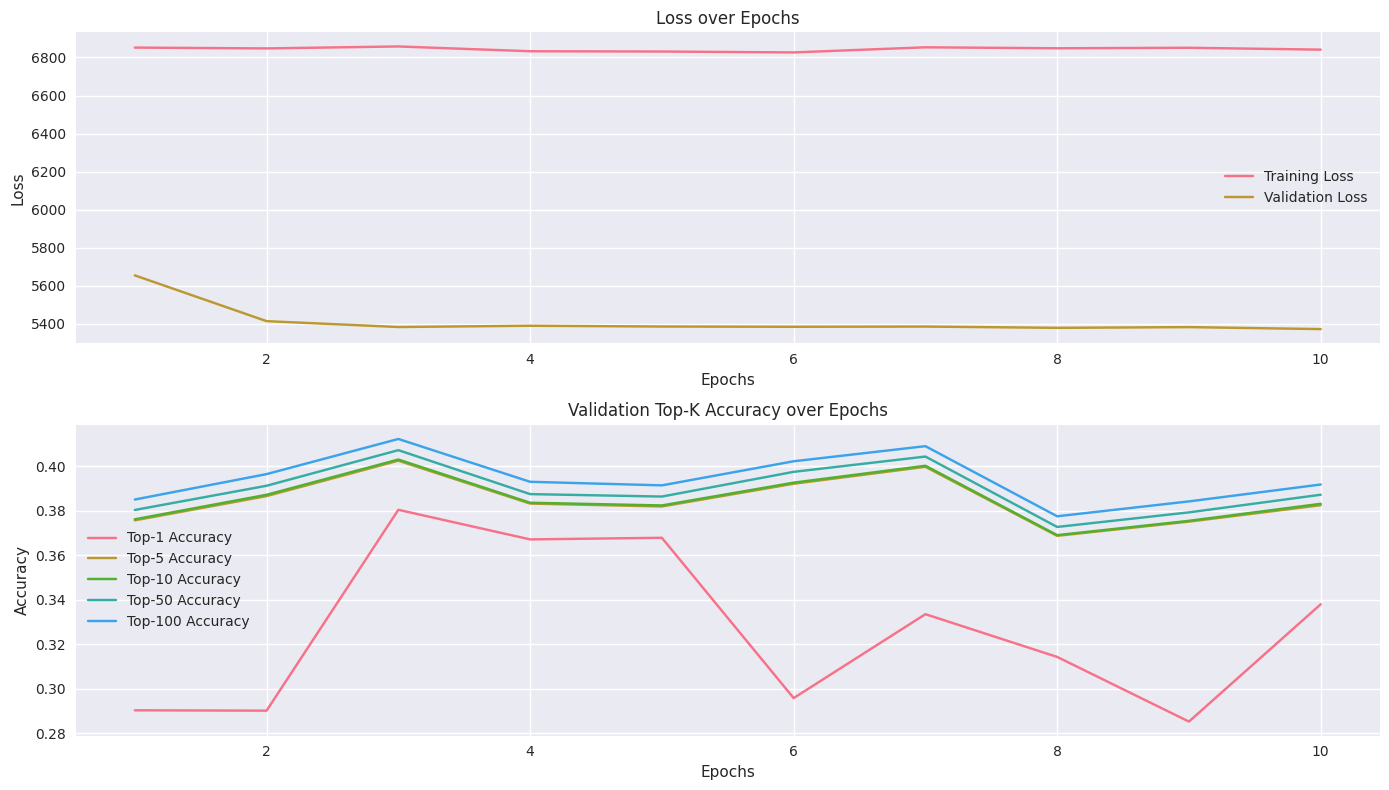

In [40]:
import matplotlib.pyplot as plt


# Plotting function
def plot_metrics(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Top-K Accuracies
    plt.subplot(2, 1, 2)
    for k in [1, 5, 10, 50, 100]:
        metric = f"val_factorized_top_k/top_{k}_categorical_accuracy"
        plt.plot(epochs, history[metric], label=f"Top-{k} Accuracy")

    plt.title("Validation Top-K Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot
#plot_metrics(history)
plot_metrics(model_history.history)


In [10]:
import os
os.makedirs("model_checkpoints", exist_ok=True)

# Save weights
model.save_weights("model_checkpoints/two_tower_weights")

In [4]:
query_df = train_df[QUERY_FEATURES]


## Load and save the query and item models on hopsworks

In [5]:
import hopsworks

project = hopsworks.login()
mr = project.get_model_registry()

2025-05-27 17:09:58,500 INFO: Initializing external client
2025-05-27 17:09:58,500 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-27 17:09:59,962 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


In [41]:
import tensorflow as tf

# Connect to Hopsworks Model Registry
mr = project.get_model_registry()

# Create a wrapper module for the query model
class QueryModelModule(tf.Module):
    def __init__(self, query_model):
        self.query_model = query_model

    @tf.function()
    def compute_emb(self, instances):
        query_emb = self.query_model(instances)
        return {
            "user_id": instances["user_id"],
            "user_city": instances["user_city"],
            "age": instances["age"],
            "user_interests": instances["user_interests"],
            "query_emb": query_emb,
        }

# Wrap query_model
query_model = QueryModelModule(model.query_model)

In [42]:

# Define features for query and candidate towers (retrieval model only)
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "title","event_type", "event_city"]

In [43]:

# Define the input specifications for the instances
instances_spec = {
    'user_id': tf.TensorSpec(shape=(None,), dtype=tf.string, name='user_id'),   # Specification for user IDs
    'user_city': tf.TensorSpec(shape=(None,), dtype=tf.string, name='user_city'),    # Specification for user city
    'user_interests': tf.TensorSpec(shape=(None,), dtype=tf.string, name='user_interests'), # Specification for user interests
    'age': tf.TensorSpec(shape=(None,), dtype=tf.int64, name='age'),              # Specification for age
}

# Get the concrete function for the query_model's compute_emb function using the specified input signatures
signatures = query_model.compute_emb.get_concrete_function(instances_spec)

# Save the query_model along with the concrete function signatures
tf.saved_model.save(
    query_model,           # The model to save
    "query_model",         # Path to save the model
    signatures=signatures, # Concrete function signatures to include
)

tf.saved_model.save(
    model.item_model,    # The model to save
    "candidate_model",   # Path to save the model
)

2025-05-29 17:54:34,165 INFO: Function `compute_emb` contains input name(s) table_handle, 8201333, 8201343, 8201359, resource with unsupported characters which will be renamed to query_tower_sequential_string_lookup_none_lookup_lookuptablefindv2_table_handle, query_tower_embedding_2_embedding_lookup_8201333, query_tower_sequential_1_embedding_1_embedding_lookup_8201343, query_tower_sequential_embedding_embedding_lookup_8201359, query_tower_sequential_2_dense_1_biasadd_readvariableop_resource in the SavedModel.
INFO:tensorflow:Assets written to: query_model/assets
2025-05-29 17:54:44,610 INFO: Assets written to: query_model/assets
INFO:tensorflow:Assets written to: candidate_model/assets
2025-05-29 17:54:50,546 INFO: Assets written to: candidate_model/assets


In [44]:

from hsml.schema import Schema
from hsml.model_schema import ModelSchema

query_df = train_df[QUERY_FEATURES]

# Infer input schema from data.
query_model_input_schema = Schema(query_df)

# Manually specify output schema.
query_model_output_schema = Schema([{
    "name": "query_embedding",
    "type": "float32",
    "shape": [EMBED_DIM],
}])

query_model_schema = ModelSchema(
    input_schema=query_model_input_schema,
    output_schema=query_model_output_schema,
)

query_model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'user_id', 'type': 'object'},
   {'name': 'user_city', 'type': 'object'},
   {'name': 'age', 'type': 'int64'},
   {'name': 'user_interests', 'type': 'object'}]},
 'output_schema': {'tensor_schema': [{'name': 'query_embedding',
    'shape': '[32]',
    'type': 'float32'}]}}

In [45]:

# Sample a query example from the query DataFrame
query_example = query_df.sample().to_dict("records")

# Create a tensorflow model for the query_model in the Model Registry 
mr_query_model = mr.tensorflow.create_model(
    name="query_model",                                           # Name of the model
    description="Model that generates query embeddings from user features",  # Description of the model
    input_example=query_example,                                  # Example input for the model
    model_schema=query_model_schema,                              # Schema of the model
)

# Save the query_model to the Model Registry
mr_query_model.save("query_model")                                # Path to save the model

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/query_model/fingerprint.pb: 0.000%|          | 0…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/query_model/saved_model.pb: 0.000%|          | 0…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/query_model/variables/variables.index: 0.000%|  …

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/query_model/variables/variables.data-00000-of-00…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/input_example.json: 0.000%|          | 0/91 elap…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/model_schema.json: 0.000%|          | 0/494 elap…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1220788/models/query_model/1


Model(name: 'query_model', version: 1)

In [46]:
# Define the input schema for the candidate_model based on item_df
candidate_model_input_schema = Schema(item_df)

# Define the output schema for the candidate_model, specifying the shape and type of the output
candidate_model_output_schema = Schema([{
    "name": "candidate_embedding",   # Name of the output feature
    "type": "float32",               # Data type of the output feature
    "shape": [EMBED_DIM],              # Shape of the output feature
}])

# Combine the input and output schemas to create the overall model schema for the candidate_model
candidate_model_schema = ModelSchema(
    input_schema=candidate_model_input_schema,    # Input schema for the model
    output_schema=candidate_model_output_schema,  # Output schema for the model
)

# Sample a candidate example from the item DataFrame
candidate_example = item_df.sample().to_dict("records")

# Create a tensorflow model for the candidate_model in the Model Registry
mr_candidate_model = mr.tensorflow.create_model(
    name="candidate_model",                                        # Name of the model
    description="Model that generates candidate embeddings from video features",  # Description of the model
    input_example=candidate_example,                              # Example input for the model
    model_schema=candidate_model_schema,                          # Schema of the model
)

# Save the candidate_model to the Model Registry
mr_candidate_model.save("candidate_model")                        # Path to save the model

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/candidate_model/fingerprint.pb: 0.000%|         …

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/candidate_model/saved_model.pb: 0.000%|         …

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/candidate_model/variables/variables.index: 0.000…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/candidate_model/variables/variables.data-00000-o…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/input_example.json: 0.000%|          | 0/153 ela…

Uploading /home/nkama/masters_thesis_project/thesis/notebooks/model_schema.json: 0.000%|          | 0/499 elap…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1220788/models/candidate_model/1


Model(name: 'candidate_model', version: 1)

---

# Model implementation to compare with baseline models

#### Creating cold users data


In [4]:

# Load the datasets
users_df = fs.get_feature_group(name="users", version=1).read()
events_df = fs.get_feature_group(name="events", version=1).read()
interactions_df = fs.get_feature_group(name="interactions", version=1).read()

# Rename columns in events_df
events_df.rename(columns={
    'category': 'event_type',
}, inplace=True)

# Merge DataFrames
full_users_df = interactions_df.merge(users_df, on="user_id", suffixes=('', '_user')).merge(events_df, on="event_id", suffixes=('', '_event'))
print("full data with cold users:", len(full_users_df))

# 1. Simulate cold users: 10% of users not in training set
all_user_ids = users_df["user_id"].unique()
cold_user_ids = np.random.choice(all_user_ids, size=int(0.10 * len(all_user_ids)), replace=False)
print("cold users:", len(cold_user_ids))

# Create DataFrame for cold users
cold_users_df = full_users_df[full_users_df["user_id"].isin(cold_user_ids)].copy()
cold_test_interactions = interactions_df[
    interactions_df["user_id"].isin(cold_user_ids) &
    interactions_df["event_id"].isin(events_df["event_id"])
].copy()

if cold_test_interactions.empty:
    print("No interactions found for cold-start users.")
print(len(cold_test_interactions))

# Merge cold test interactions with cold users DataFrame
merged_df = pd.merge(cold_test_interactions, cold_users_df, on="user_id", suffixes=('', '_cold'))
print(merged_df.columns)


if 'event_id' not in merged_df.columns:
    print("Error: 'event_id' column not found in merged_df.")
else:
    merged_df = pd.merge(merged_df, events_df, on="event_id", suffixes=('', '_event'))

cold_users_merged_df = merged_df[merged_df["interaction_label"] == 1]
if merged_df.empty:
    print("No positive interactions found for cold users.")
print(f"Total cold-start test users with interactions: {cold_users_merged_df['user_id'].nunique()}")

# Remove cold users from the full users DataFrame
full_users_df = full_users_df[~full_users_df["user_id"].isin(cold_user_ids)]
print("full data without cold users:", len(full_users_df))

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(full_users_df, test_size=0.1, random_state=42)
print("length of train_data:", len(train_df))
print("length of val_data:", len(val_df))


# def evaluate_cold_start_users(
#     query_model, candidate_model, ranking_model, feature_list, test_users_df, full_users_df,
#     interactions_df, events_df, weather=False, output_label="Weather"
# ):
#     print(f"\n=== COLD-START USER EVALUATION ({output_label}) ===")

#     # 3. Evaluate
#     results = integrated_retrieval_ranking_pipeline(
#         query_model=query_model,
#         candidate_model=candidate_model,
#         ranking_model=ranking_model,
#         test_interactions=merged_df,
#         feature_list=feature_list,
#         k_retrieval=1000,
#         max_k=100,
#         filter_weather=weather,
#         filter_time=False,
#         weather_score_threshold=0.4
#     )

#     # Add metadata
#     results_df = results["results_dataframe"]
#     results_df["Model"] = output_label
#     results_df["Scenario"] = "Cold Start"

#     return results_df



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.71s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.26s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (9.34s) 
full data with cold users: 500000
cold users: 4992
49987
Index(['interaction_id', 'user_id', 'event_id', 'interaction_type',
       'interaction_time', 'interaction_distance_to_event',
       'interaction_label', 'interaction_id_cold', 'event_id_cold',
       'interaction_type_cold', 'interaction_time_cold',
       'interaction_distance_to_event_cold', 'interaction_label_cold',
       'user_lat', 'user_lon', 'user_city', 'indoor_outdoor_preference', 'age',
       'user_interests', 'signup_date', 'social_connectedness',
       'user_weather_condition', 'user_temperature', 'user_precipitation',
       'title', 'event_type', 'event_lat', 'event_lon', 'event_city',
       'start_time', 'duration', 'weather_condition', 'temperature',
   

In [5]:
events_df.columns

Index(['event_id', 'title', 'event_type', 'event_lat', 'event_lon',
       'event_city', 'start_time', 'duration', 'weather_condition',
       'temperature', 'precipitation', 'attendance_rate',
       'event_indoor_capability'],
      dtype='object')

## training with warm users


In [7]:

import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict
import numpy as np


# Prepare vocabulary lists for Lookup & Embedding layers
user_id_list = train_df["user_id"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
user_city_list = train_df["user_city"].unique().tolist()
event_city_list = train_df["event_city"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()
user_interest_list = train_df["user_interests"].unique().tolist()
title_list = train_df["title"].unique().tolist()

# Print summary
print(f"✅ Training set size: {len(train_df)}")
print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")


# Reduced embedding dimension
EMBED_DIM = 32  
BATCH_SIZE = 1024
L2_REG = 0.01  
DROPOUT_RATE = 0.5  

# Define features for query and candidate towers
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# Build tf.data.Dataset with proper tensor shapes
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({
        col: tf.constant(df[col].values) for col in df.columns
    })

# Create datasets with proper batching and shuffling
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()
#test_ds = df_to_ds(test_df).batch(BATCH_SIZE).cache()

# Create item dataset with proper tensor shapes
item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
item_ds = tf.data.Dataset.from_tensor_slices({
    col: tf.constant(item_df[col].astype(str).values) for col in CANDIDATE_FEATURES
})

# Query Tower with improved regularization
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # User ID embedding with stronger L2 regularization
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)  # Max-norm constraint
            )
        ])

        # Age normalization with batch norm
        self.normalized_age = tf.keras.layers.Normalization(axis=None)
        
        # City embedding with regularization
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Text processing with int mode and reduced complexity
        self.interest_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=100,
            output_mode='multi_hot'
        )

        self.interest_embedding = tf.keras.layers.Embedding(
            input_dim=101,  # max_tokens + 1 for OOV
            output_dim=self.emb_dim//2,  # Reduced dimension
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),  # Added activity regularization
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text features
        interests_encoded = self.interest_vectorizer(inputs["user_interests"])
        interests_embedding = self.interest_embedding(interests_encoded)
        pooled_interests = tf.reduce_mean(interests_embedding, axis=1)
        
        # Process city with embedding instead of one-hot
        city_emb = self.city_embedding(inputs["user_city"])
        
        # Add Gaussian noise during training for better generalization
        age_normalized = self.normalized_age(inputs["age"])
        if training:
            age_normalized = age_normalized + tf.random.normal(
                tf.shape(age_normalized), mean=0.0, stddev=0.1
            )
        
        # Concatenate features
        combined = tf.concat([
            self.user_embedding(inputs["user_id"]),
            tf.reshape(age_normalized, (-1, 1)),
            city_emb,
            pooled_interests
        ], axis=1)

        return self.fnn(combined)

# Item Tower with improved regularization
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # Event ID embedding with stronger L2 regularization
        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Type and city embeddings with regularization
        self.type_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_type_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_type_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])
        
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Simplified title processing
        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=500,  # Reduced from 1000
            output_mode='int',
            output_sequence_length=10  # Reduced from 20
        )
        self.title_embedding = tf.keras.layers.Embedding(
            input_dim=501, 
            output_dim=32,  # Reduced from 64
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )
        self.title_pool = tf.keras.layers.GlobalAveragePooling1D()  # Simpler pooling

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text with simpler approach
        title_encoded = self.title_vectorizer(inputs["title"])
        title_embedding = self.title_embedding(title_encoded)
        pooled_title = self.title_pool(title_embedding)
        
        # Process categorical features with embeddings
        type_emb = self.type_embedding(inputs["event_type"])
        city_emb = self.city_embedding(inputs["event_city"])
        
        # Concatenate features
        combined = tf.concat([
            self.event_embedding(inputs["event_id"]),
            type_emb,
            city_emb,
            pooled_title
        ], axis=1)

        return self.fnn(combined)
    
# Initialize models
query_model = QueryTower()
item_model = ItemTower()

# Adapt layers to training data
query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"].values)
item_model.title_vectorizer.adapt(item_df["title"].values)

# Initialize models with sample data
query_sample = next(iter(df_to_ds(train_df[QUERY_FEATURES]).batch(1)))
item_sample = next(iter(df_to_ds(item_df[CANDIDATE_FEATURES]).batch(1)))
_ = query_model(query_sample)
_ = item_model(item_sample)

# Fixed Two-Tower Model with proper candidate handling
class TwoTowerModel(tfrs.models.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        
        # Temperature parameter for scaling similarity scores
        self.temperature = tf.Variable(0.2, trainable=True)  # Increased from 0.1
        
        # Create candidates dataset with proper batching and mapping
        candidates = item_ds.batch(BATCH_SIZE).map(
            lambda x: (x["event_id"], self.item_model(x))
        )

        
        # Set up retrieval task with factorized top-k
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=candidates
            ),
            temperature=self.temperature
        )
    def call(self, features):
        query_inputs = {k: features[k] for k in QUERY_FEATURES}
        item_inputs = {k: features[k] for k in CANDIDATE_FEATURES}
        return self.query_model(query_inputs), self.item_model(item_inputs)

    
    def compute_loss(self, features, training=False):
        query_inputs = {k: features[k] for k in QUERY_FEATURES}
        item_inputs = {k: features[k] for k in CANDIDATE_FEATURES}

        query_embeddings = self.query_model(query_inputs, training=training)
        item_embeddings = self.item_model(item_inputs, training=training)

        return self.task(query_embeddings, item_embeddings)


# Create and compile model with optimized learning rate
model = TwoTowerModel(query_model, item_model)

# Optimizer with learning rate schedule and weight decay
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=5e-4,  # Reduced from 1e-3
        decay_steps=10000
    ),
    weight_decay=0.01,  # Increased from 0.004
    clipnorm=1.0
)

model.compile(optimizer=optimizer)

# Train with early stopping and learning rate reduction
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            patience=10,  # Increased patience
            restore_best_weights=True,
            min_delta=0.001  # Minimum improvement required
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
        
    ]
)

# Evaluate final performance
eval_results = model.evaluate(
    val_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")


✅ Training set size: 405011
📌 Unique Users: 44914, Events: 9999
Epoch 1/10


2025-06-27 07:34:03.155311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 290 of 10240
2025-06-27 07:34:07.981691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


396/396 [==============================] - 158s 347ms/step - factorized_top_k/top_1_categorical_accuracy: 0.3478 - factorized_top_k/top_5_categorical_accuracy: 0.4400 - factorized_top_k/top_10_categorical_accuracy: 0.4520 - factorized_top_k/top_50_categorical_accuracy: 0.4634 - factorized_top_k/top_100_categorical_accuracy: 0.4654 - loss: 9832.4168 - regularization_loss: 5.4745 - total_loss: 9837.8914 - val_factorized_top_k/top_1_categorical_accuracy: 0.2996 - val_factorized_top_k/top_5_categorical_accuracy: 0.5970 - val_factorized_top_k/top_10_categorical_accuracy: 0.5970 - val_factorized_top_k/top_50_categorical_accuracy: 0.5970 - val_factorized_top_k/top_100_categorical_accuracy: 0.5970 - val_loss: 6670.9746 - val_regularization_loss: 3.4404 - val_total_loss: 6674.4150 - lr: 4.9808e-04
Epoch 2/10


2025-06-27 07:36:35.796523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 236 of 10240
2025-06-27 07:36:45.923827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


396/396 [==============================] - 151s 330ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4948 - factorized_top_k/top_5_categorical_accuracy: 0.4948 - factorized_top_k/top_10_categorical_accuracy: 0.4948 - factorized_top_k/top_50_categorical_accuracy: 0.4948 - factorized_top_k/top_100_categorical_accuracy: 0.4948 - loss: 7088.5851 - regularization_loss: 2.8992 - total_loss: 7091.4843 - val_factorized_top_k/top_1_categorical_accuracy: 0.4676 - val_factorized_top_k/top_5_categorical_accuracy: 0.5917 - val_factorized_top_k/top_10_categorical_accuracy: 0.5917 - val_factorized_top_k/top_50_categorical_accuracy: 0.5917 - val_factorized_top_k/top_100_categorical_accuracy: 0.5917 - val_loss: 6670.9746 - val_regularization_loss: 2.4780 - val_total_loss: 6673.4526 - lr: 4.9232e-04
Epoch 3/10


2025-06-27 07:39:06.594428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 315 of 10240
2025-06-27 07:39:10.250411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


396/396 [==============================] - 139s 317ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5002 - factorized_top_k/top_5_categorical_accuracy: 0.5002 - factorized_top_k/top_10_categorical_accuracy: 0.5002 - factorized_top_k/top_50_categorical_accuracy: 0.5002 - factorized_top_k/top_100_categorical_accuracy: 0.5002 - loss: 7088.4971 - regularization_loss: 2.0671 - total_loss: 7090.5642 - val_factorized_top_k/top_1_categorical_accuracy: 0.3144 - val_factorized_top_k/top_5_categorical_accuracy: 0.5901 - val_factorized_top_k/top_10_categorical_accuracy: 0.5901 - val_factorized_top_k/top_50_categorical_accuracy: 0.5901 - val_factorized_top_k/top_100_categorical_accuracy: 0.5901 - val_loss: 6670.9746 - val_regularization_loss: 1.7358 - val_total_loss: 6672.7104 - lr: 4.8282e-04
Epoch 4/10


2025-06-27 07:41:25.651171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 304 of 10240
2025-06-27 07:41:29.498737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


396/396 [==============================] - 134s 303ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5000 - factorized_top_k/top_5_categorical_accuracy: 0.5000 - factorized_top_k/top_10_categorical_accuracy: 0.5000 - factorized_top_k/top_50_categorical_accuracy: 0.5000 - factorized_top_k/top_100_categorical_accuracy: 0.5000 - loss: 7088.4577 - regularization_loss: 1.4783 - total_loss: 7089.9360 - val_factorized_top_k/top_1_categorical_accuracy: 0.3270 - val_factorized_top_k/top_5_categorical_accuracy: 0.5958 - val_factorized_top_k/top_10_categorical_accuracy: 0.5958 - val_factorized_top_k/top_50_categorical_accuracy: 0.5958 - val_factorized_top_k/top_100_categorical_accuracy: 0.5958 - val_loss: 6670.9746 - val_regularization_loss: 1.2601 - val_total_loss: 6672.2349 - lr: 4.6972e-04
Epoch 5/10


2025-06-27 07:43:39.712995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 336 of 10240
2025-06-27 07:43:42.183307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


396/396 [==============================] - 136s 313ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4990 - factorized_top_k/top_5_categorical_accuracy: 0.4990 - factorized_top_k/top_10_categorical_accuracy: 0.4990 - factorized_top_k/top_50_categorical_accuracy: 0.4990 - factorized_top_k/top_100_categorical_accuracy: 0.4990 - loss: 7088.4258 - regularization_loss: 1.0213 - total_loss: 7089.4471 - val_factorized_top_k/top_1_categorical_accuracy: 0.4050 - val_factorized_top_k/top_5_categorical_accuracy: 0.6018 - val_factorized_top_k/top_10_categorical_accuracy: 0.6018 - val_factorized_top_k/top_50_categorical_accuracy: 0.6018 - val_factorized_top_k/top_100_categorical_accuracy: 0.6018 - val_loss: 6670.9746 - val_regularization_loss: 0.8262 - val_total_loss: 6671.8008 - lr: 4.5322e-04
Epoch 6/10


2025-06-27 07:45:56.242630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 299 of 10240
2025-06-27 07:46:00.238293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


396/396 [==============================] - 135s 306ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5003 - factorized_top_k/top_5_categorical_accuracy: 0.5003 - factorized_top_k/top_10_categorical_accuracy: 0.5003 - factorized_top_k/top_50_categorical_accuracy: 0.5003 - factorized_top_k/top_100_categorical_accuracy: 0.5003 - loss: 7088.3804 - regularization_loss: 0.7115 - total_loss: 7089.0919 - val_factorized_top_k/top_1_categorical_accuracy: 0.4424 - val_factorized_top_k/top_5_categorical_accuracy: 0.6047 - val_factorized_top_k/top_10_categorical_accuracy: 0.6047 - val_factorized_top_k/top_50_categorical_accuracy: 0.6047 - val_factorized_top_k/top_100_categorical_accuracy: 0.6047 - val_loss: 6670.9746 - val_regularization_loss: 0.6293 - val_total_loss: 6671.6040 - lr: 4.3358e-04
Epoch 7/10


2025-06-27 07:48:11.650687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 304 of 10240
2025-06-27 07:48:15.617245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


396/396 [==============================] - 144s 329ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5019 - factorized_top_k/top_5_categorical_accuracy: 0.5019 - factorized_top_k/top_10_categorical_accuracy: 0.5019 - factorized_top_k/top_50_categorical_accuracy: 0.5019 - factorized_top_k/top_100_categorical_accuracy: 0.5019 - loss: 7088.3740 - regularization_loss: 0.5361 - total_loss: 7088.9101 - val_factorized_top_k/top_1_categorical_accuracy: 0.1327 - val_factorized_top_k/top_5_categorical_accuracy: 0.5306 - val_factorized_top_k/top_10_categorical_accuracy: 0.5306 - val_factorized_top_k/top_50_categorical_accuracy: 0.5306 - val_factorized_top_k/top_100_categorical_accuracy: 0.5306 - val_loss: 6670.9746 - val_regularization_loss: 0.4535 - val_total_loss: 6671.4282 - lr: 4.1110e-04
Epoch 8/10


2025-06-27 07:50:35.968254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 282 of 10240
2025-06-27 07:50:41.332516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


396/396 [==============================] - 148s 336ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5006 - factorized_top_k/top_5_categorical_accuracy: 0.5006 - factorized_top_k/top_10_categorical_accuracy: 0.5006 - factorized_top_k/top_50_categorical_accuracy: 0.5006 - factorized_top_k/top_100_categorical_accuracy: 0.5006 - loss: 7088.3692 - regularization_loss: 0.3897 - total_loss: 7088.7589 - val_factorized_top_k/top_1_categorical_accuracy: 0.3025 - val_factorized_top_k/top_5_categorical_accuracy: 0.5779 - val_factorized_top_k/top_10_categorical_accuracy: 0.5779 - val_factorized_top_k/top_50_categorical_accuracy: 0.5779 - val_factorized_top_k/top_100_categorical_accuracy: 0.5779 - val_loss: 6670.9746 - val_regularization_loss: 0.3418 - val_total_loss: 6671.3164 - lr: 3.8614e-04
Epoch 9/10


2025-06-27 07:53:04.403501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 282 of 10240
2025-06-27 07:53:09.532662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


396/396 [==============================] - 140s 317ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5002 - factorized_top_k/top_5_categorical_accuracy: 0.5002 - factorized_top_k/top_10_categorical_accuracy: 0.5002 - factorized_top_k/top_50_categorical_accuracy: 0.5002 - factorized_top_k/top_100_categorical_accuracy: 0.5002 - loss: 7088.3621 - regularization_loss: 0.2947 - total_loss: 7088.6568 - val_factorized_top_k/top_1_categorical_accuracy: 0.1648 - val_factorized_top_k/top_5_categorical_accuracy: 0.6334 - val_factorized_top_k/top_10_categorical_accuracy: 0.6334 - val_factorized_top_k/top_50_categorical_accuracy: 0.6334 - val_factorized_top_k/top_100_categorical_accuracy: 0.6334 - val_loss: 6670.9746 - val_regularization_loss: 0.2596 - val_total_loss: 6671.2344 - lr: 3.5907e-04
Epoch 10/10


2025-06-27 07:55:25.247391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 309 of 10240
2025-06-27 07:55:29.221400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


44/44 [==============================] - 12s 267ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4486 - factorized_top_k/top_5_categorical_accuracy: 0.6667 - factorized_top_k/top_10_categorical_accuracy: 0.6667 - factorized_top_k/top_50_categorical_accuracy: 0.6667 - factorized_top_k/top_100_categorical_accuracy: 0.6667 - loss: 7078.8564 - regularization_loss: 0.2080 - total_loss: 7079.0644

Final Evaluation Metrics:
factorized_top_k/top_1_categorical_accuracy: 0.4486
factorized_top_k/top_5_categorical_accuracy: 0.6667
factorized_top_k/top_10_categorical_accuracy: 0.6667
factorized_top_k/top_50_categorical_accuracy: 0.6667
factorized_top_k/top_100_categorical_accuracy: 0.6667
loss: 6670.9746
regularization_loss: 0.2080
total_loss: 6671.1826


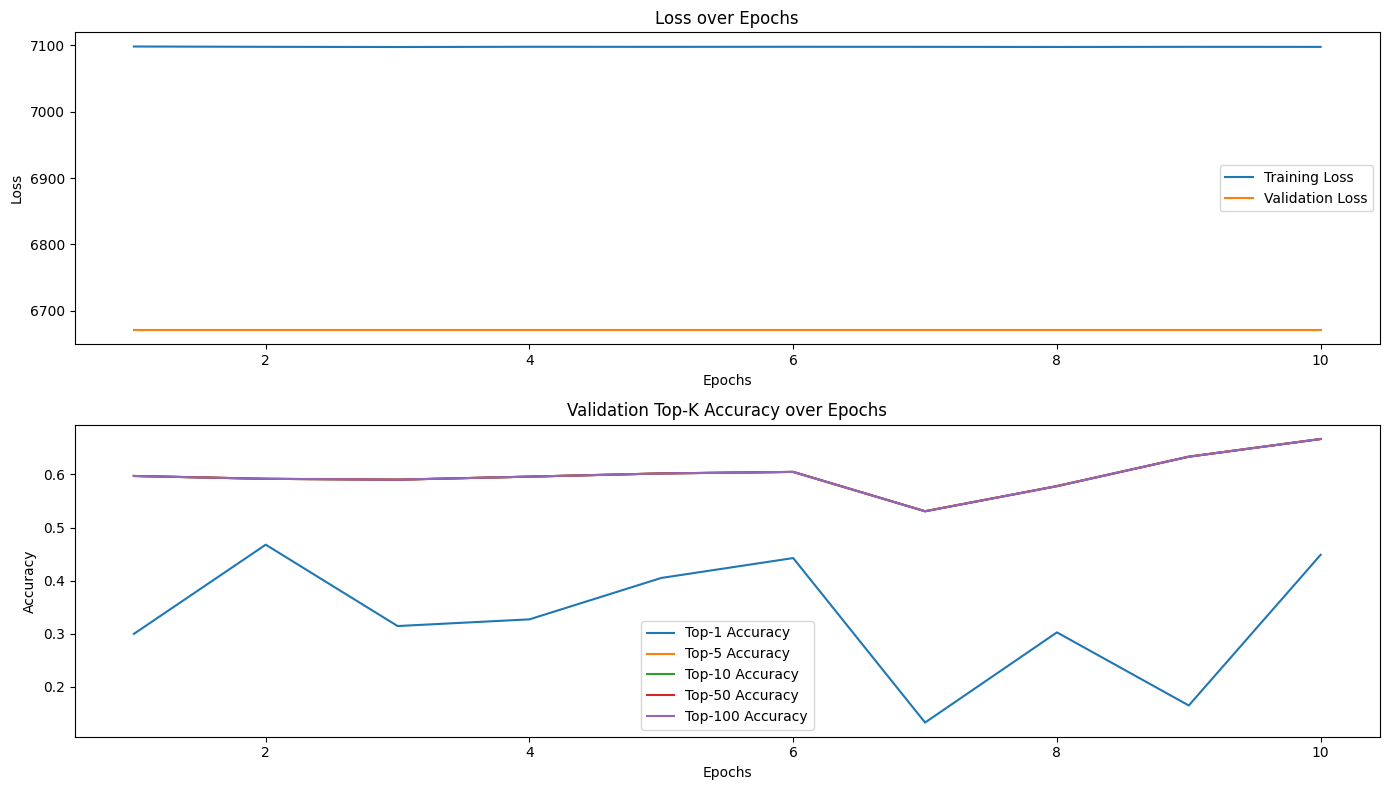

In [8]:

import matplotlib.pyplot as plt

# Plotting function
def plot_metrics(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Top-K Accuracies
    plt.subplot(2, 1, 2)
    for k in [1, 5, 10, 50, 100]:
        metric = f"val_factorized_top_k/top_{k}_categorical_accuracy"
        plt.plot(epochs, history[metric], label=f"Top-{k} Accuracy")

    plt.title("Validation Top-K Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_metrics(model_history.history)

## Model evaluation 

### evaluation on warm users

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier, Pool
import joblib
import math
from datetime import datetime

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

test_users = train_df["user_id"].unique()[:4000]
users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]


print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

merged_df = pd.merge(interactions_df, users_df, on='user_id')
merged_df = pd.merge(merged_df, events_df, on='event_id')
test_interactions = merged_df[merged_df["user_id"].isin(test_users)].sample(frac=1.0, random_state=42)
print(f"Test interactions: {len(test_interactions)}")

# Verify conversion
print("Sample user_id in interactions data after conversion:", interactions_df["user_id"].head().tolist())
print("Sample user_id in users data after conversion:", users_df["user_id"].head().tolist())

# Print the first few user IDs from each dataset to compare
print("\nFirst 10 user IDs in interactions_df:", sorted(list(interactions_df["user_id"].unique()))[:10])
print("First 10 user IDs in users_df:", sorted(list(users_df["user_id"].unique()))[:10])

# Check intersection properly
common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
print(f"Number of common users: {len(common_users)}")
print("First 10 common user IDs:", sorted(list(common_users))[:10])

# Filter interactions to only include users that exist in the users dataset
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
print(f"Filtered interactions with valid users: {len(interactions_df)}")

# Check intersection of event IDs
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
print(f"Number of common events: {len(common_events)}")
print("First 10 common event IDs:", sorted(list(common_events))[:10])

# Filter interactions to only include events that exist in the events dataset
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]
print(f"Filtered interactions with valid events: {len(interactions_df)}")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type"]

NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city','title',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city','title', 
       'weather_condition', 'temperature','precipitation', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'indoor_outdoor_preference',
       'age', 'user_interests','user_weather_condition', 'user_temperature','user_precipitation']



# Print data info
print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")



2025-06-27 07:57:58,587 INFO: Loading faiss with AVX2 support.
2025-06-27 07:57:58,685 INFO: Successfully loaded faiss with AVX2 support.
2025-06-27 07:57:58,695 INFO: Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.
Users: 49923, Events: 9999, Interactions: 500000
Unique users: 49914
Unique events: 9999
Test interactions: 44470
Sample user_id in interactions data after conversion: ['LE249D', 'OX425G', 'LK101E', 'ID377X', 'TR667Y']
Sample user_id in users data after conversion: ['AQ338K', 'CD426N', 'QI727I', 'QJ569X', 'UR732K']

First 10 user IDs in interactions_df: ['AA048W', 'AA052G', 'AA067T', 'AA108M', 'AA123D', 'AA128J', 'AA138Q', 'AA154P', 'AA164C', 'AA168Y']
First 10 user IDs in users_df: ['AA048W', 'AA052G', 'AA067T', 'AA108M', 'AA123D', 'AA128J', 'AA138Q', 'AA154P', 'AA164C', 'AA168Y']
Number of common users: 49914
First 10 common user IDs: ['AA048W', 'AA052G', 'AA067T', 'AA108M', 'AA123D', 'AA128J', 'AA138Q', 'AA

Starting evaluation pipeline for retrieval and ranking models...
Current date: Wednesday, May 14, 2025, 1:03 PM CEST

Evaluating Integrated Retrieval-Ranking Pipeline (Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully
Processed 400 users successfully
Processed 500 users successfully
Processed 600 users successfully
Processed 700 users successfully
Processed 800 users successfully
Processed 900 users successfully
Processed 1000 users successfully
Processed 1100 users successfully
Processed 1200 users successfully
Processed 1300 users successfully
Processed 1400 users successfully
Processed 1500 users successfully
Processed 1600 users successfully
Processed 1700 users successfully
Processed 1800 users successfully
Processed 1900 users successfully


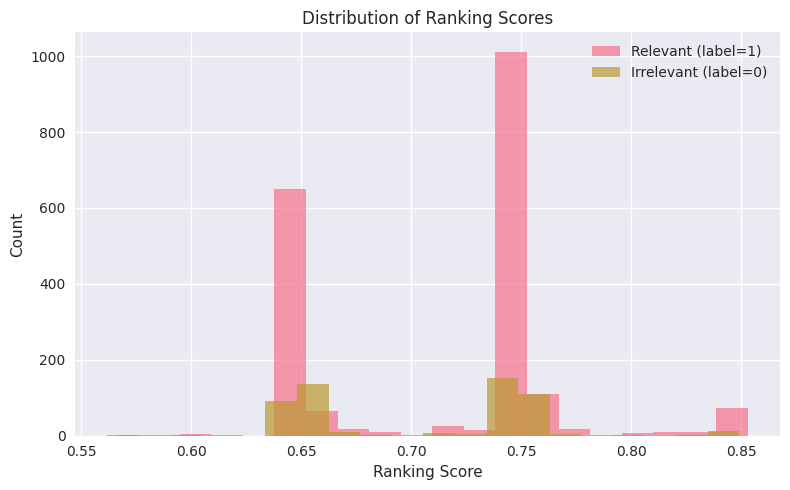


Evaluation Results:
Total users evaluated: 4000
Users with successful evaluation: 1911

Recall@K:
Recall@1: 0.0942
Recall@10: 0.1319
Recall@50: 0.1319
Recall@100: 0.1319

Precision@K:
Precision@1: 0.7342
Precision@10: 0.1068
Precision@50: 0.0214
Precision@100: 0.0107

NDCG@K:
NDCG@1: 0.7342
NDCG@10: 0.7719
NDCG@50: 0.7719
NDCG@100: 0.7719

MRR: 0.7648
Average Precision: 0.8254


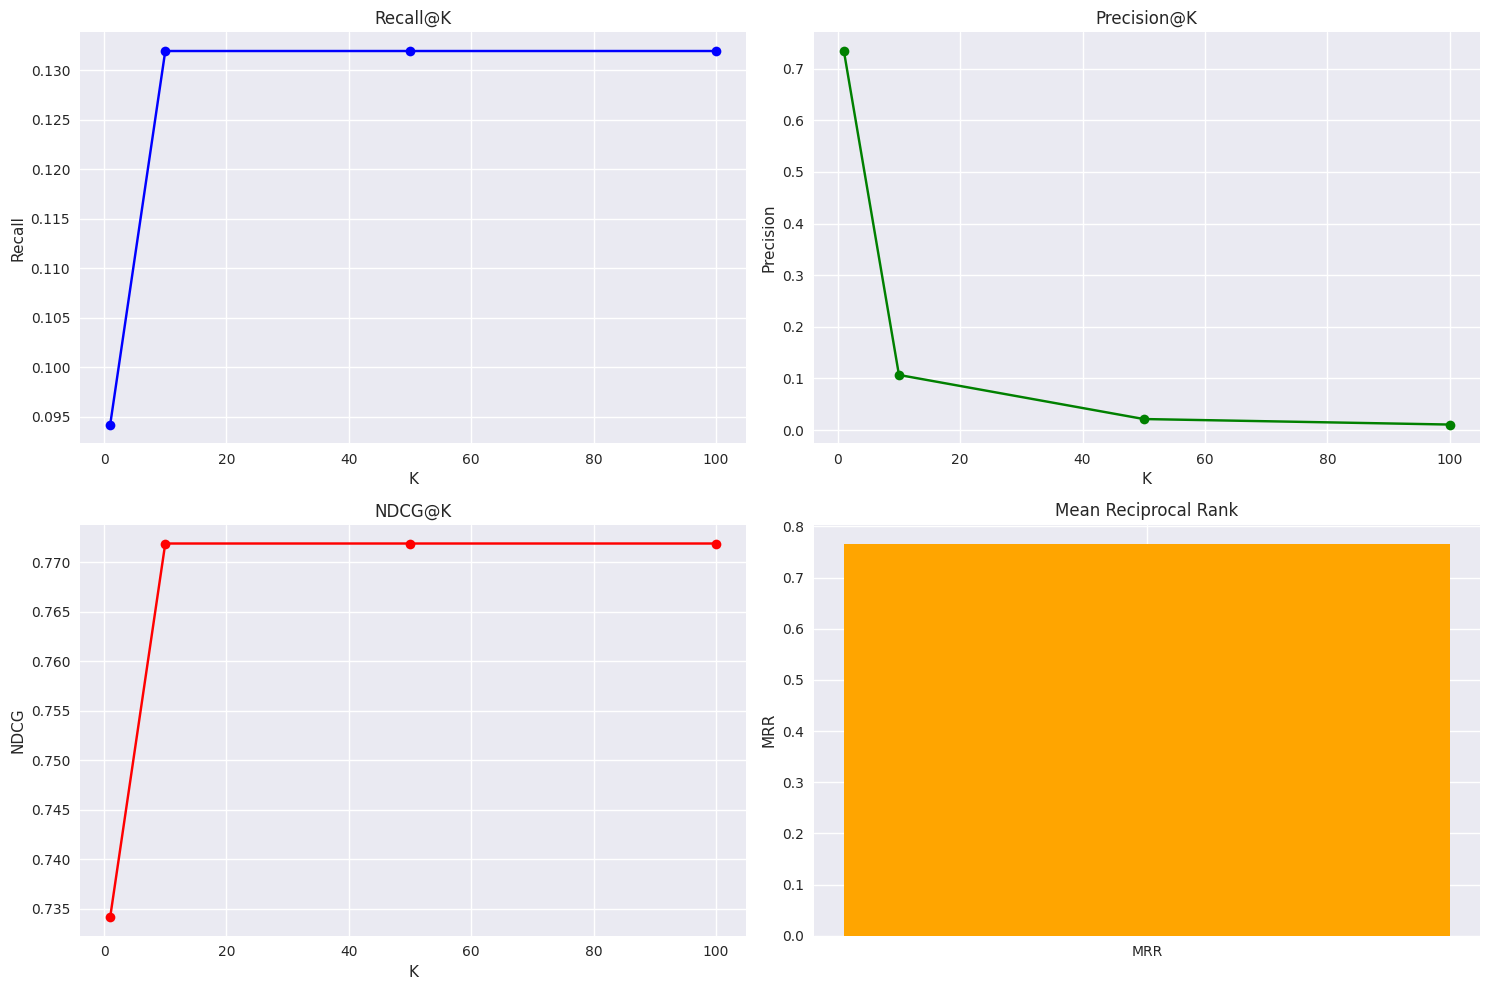

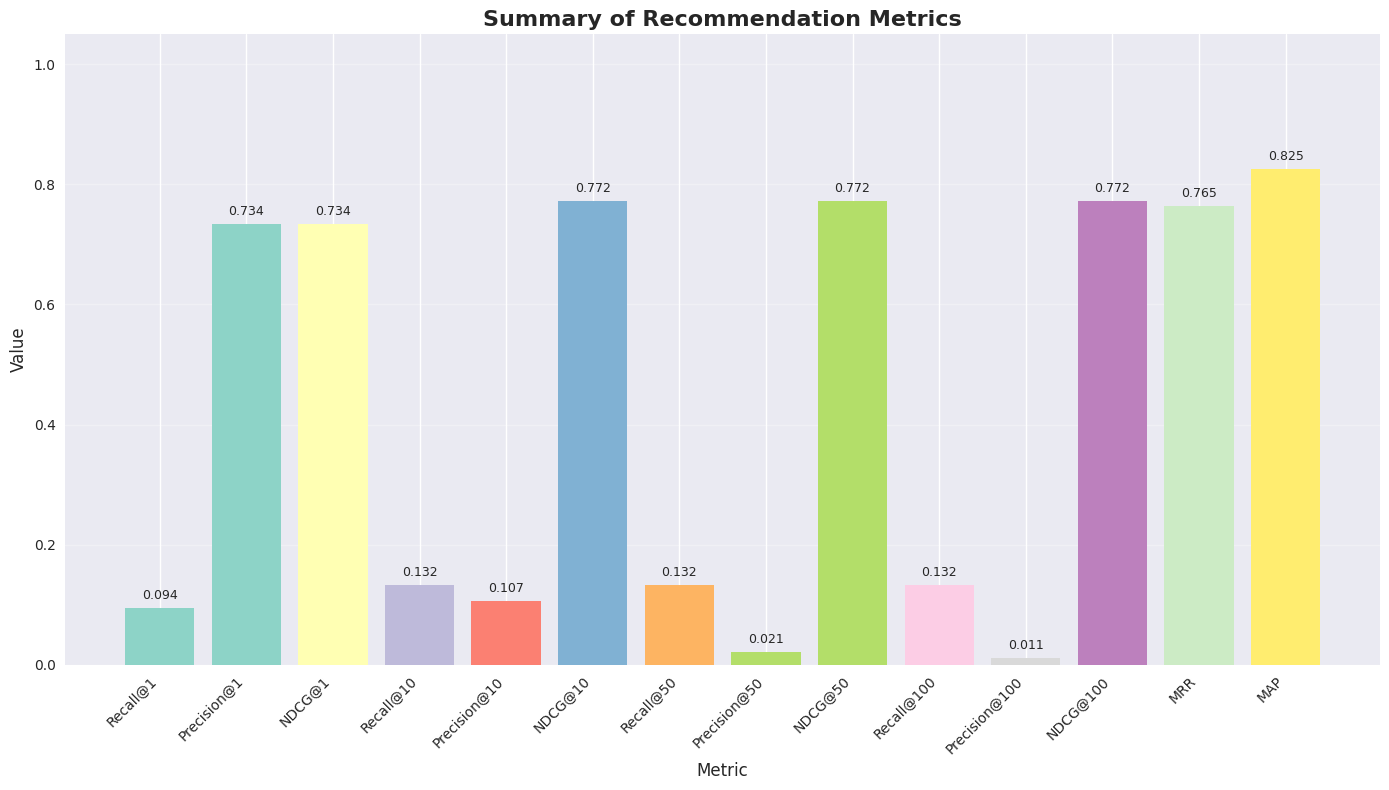


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully
Processed 400 users successfully
Processed 500 users successfully
Processed 600 users successfully
Processed 700 users successfully
Processed 800 users successfully
Processed 900 users successfully
Processed 1000 users successfully
Processed 1100 users successfully
Processed 1200 users successfully
Processed 1300 users successfully
Processed 1400 users successfully
Processed 1500 users successfully
Processed 1600 users successfully
Processed 1700 users successfully
Processed 1800 users successfully
Processed 1900 users successfully
Processed 2000 users successfully
Processed 2100 users successfully
Processed 2200 users successfully
Processed 2300 users successfully
Processed 2400 users successfully
Processed 2500 users successfully
Processed 2600 users successfull

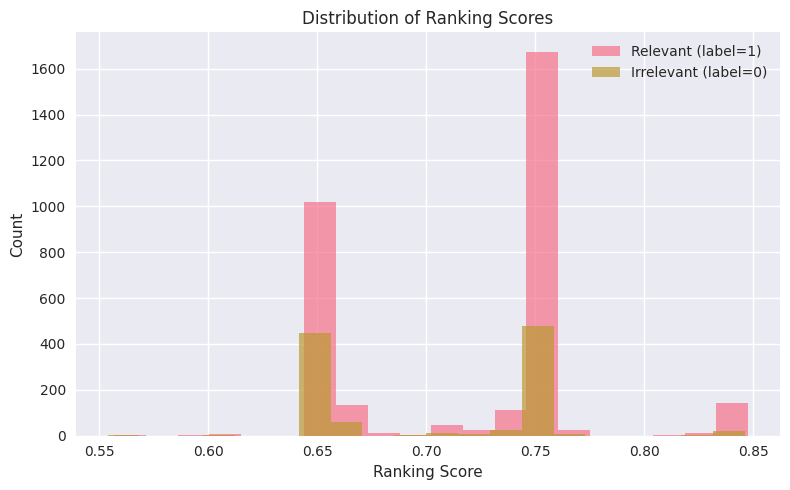


Evaluation Results:
Total users evaluated: 4000
Users with successful evaluation: 2692

Recall@K:
Recall@1: 0.0947
Recall@10: 0.1490
Recall@50: 0.1490
Recall@100: 0.1490

Precision@K:
Precision@1: 0.7270
Precision@10: 0.1194
Precision@50: 0.0239
Precision@100: 0.0119

NDCG@K:
NDCG@1: 0.7270
NDCG@10: 0.7859
NDCG@50: 0.7859
NDCG@100: 0.7859

MRR: 0.7737
Average Precision: 0.7897


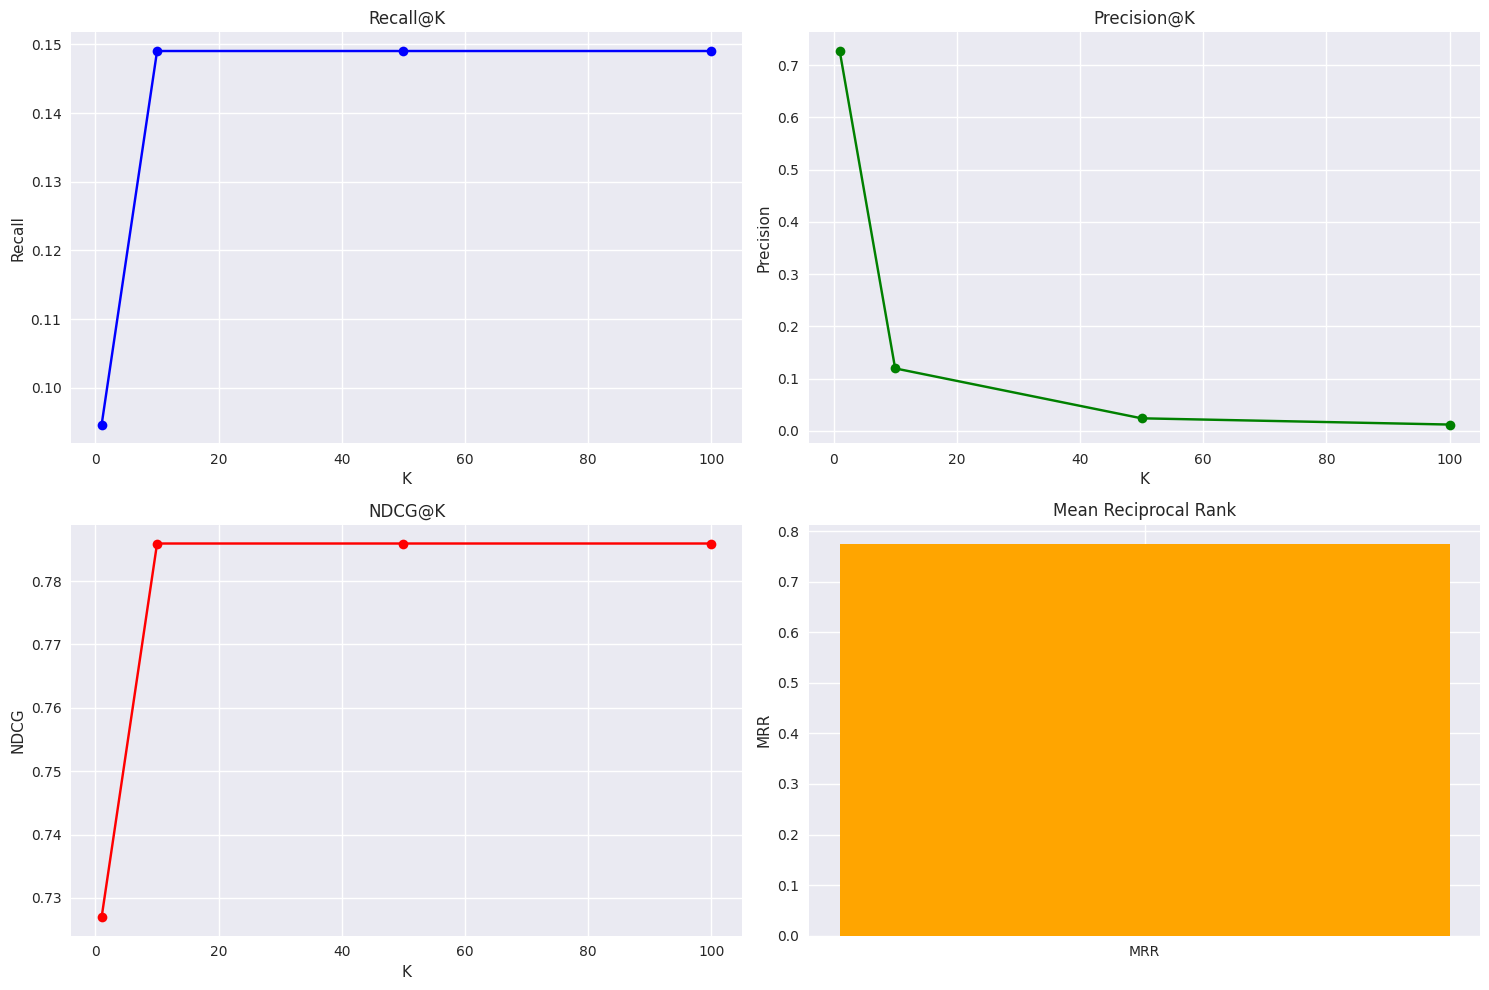

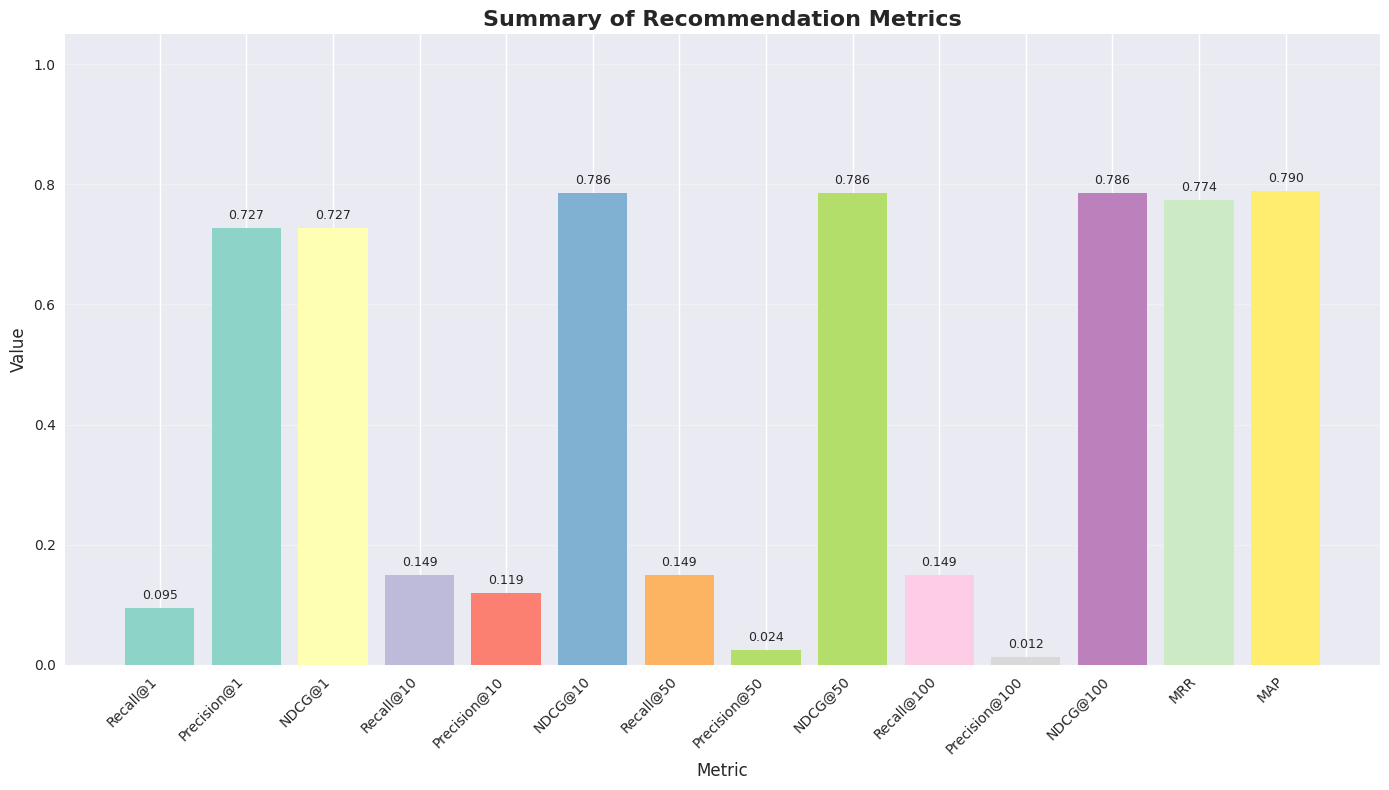


Comparison of Integrated Pipelines:
Weather Model MRR: 0.7648
No-Weather Model MRR: 0.7737
Weather features decrease MRR by 1.16%

Evaluation pipeline complete!

Results saved to CSV files:
- weather_model_results.csv
- no_weather_model_results.csv
- combined_retrieval_ranking_results.csv

Combined Results Summary:
     Model   k  Precision   Recall      MRR     NDCG  Coverage
   Weather   1   0.734171 0.094216 0.764826 0.734171   0.47775
   Weather  10   0.106750 0.131924 0.764826 0.771871   0.47775
   Weather  50   0.021350 0.131924 0.764826 0.771871   0.47775
   Weather 100   0.010675 0.131924 0.764826 0.771871   0.47775
No_Weather   1   0.726969 0.094652 0.773712 0.726969   0.67300
No_Weather  10   0.119428 0.149034 0.773712 0.785941   0.67300
No_Weather  50   0.023886 0.149034 0.773712 0.785941   0.67300
No_Weather 100   0.011943 0.149034 0.773712 0.785941   0.67300


In [10]:


def get_user_embeddings(query_model, user_ids):
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    if batch_users.empty:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    return query_model(batch_input).numpy()

def get_event_embeddings(candidate_model, events_data=None):
    if events_data is None:
        events_data = events_df.copy()
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    event_ids = []
    event_embeddings = []
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    return np.vstack(event_embeddings), event_ids

def build_faiss_index(embeddings):
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    return index

# --- Robust weather match scoring ---

def compute_weather_match(user_weather, event_weather, user_pref, event_type_val, user_temp, event_temp, user_precip, event_precip):
    score = 0.0
    # Weather group match (0.4)
    if user_weather == event_weather:
        score += 0.4
    elif (user_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy'] and event_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy']):
        score += 0.2
    elif (user_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm'] and event_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm']):
        score += 0.2
    # Indoor/outdoor preference match (0.3)
    if user_pref == 'any':
        score += 0.3
    elif (user_pref == 'indoor' and event_type_val in ['Indoor', 'Hybrid']) or (user_pref == 'outdoor' and event_type_val in ['Outdoor', 'Hybrid']):
        score += 0.3
    # Temperature and precipitation compatibility (0.3)
    temp_diff = abs(user_temp - event_temp)
    precip_diff = abs(user_precip - event_precip)
    temp_score = max(0, 1 - (temp_diff / 20))
    precip_score = max(0, 1 - (precip_diff / 10))
    score += 0.3 * (0.6 * temp_score + 0.4 * precip_score)
    return round(score, 2)

def post_retrieval_filtering(candidates_df, user_context, filter_weather=True, filter_time=True, max_distance_km=500, weather_score_threshold=0.2):
    if filter_time and 'start_time' in candidates_df.columns:
        now = pd.Timestamp.now(tz='UTC')
        candidates_df = candidates_df[
            pd.to_datetime(candidates_df['start_time'], utc=True) > now
        ]
    # Location proximity filtering
    if 'interaction_distance_to_event' in candidates_df.columns:
        candidates_df = candidates_df[candidates_df['interaction_distance_to_event'] <= max_distance_km]
    # Weather filtering
    if filter_weather:
        scores = []
        for _, event in candidates_df.iterrows():
            score = compute_weather_match(
                user_context.get('user_weather_condition', 'any'),
                event.get('weather_condition', 'unknown'),
                user_context.get('indoor_outdoor_preference', 'any'),
                event.get('event_type', 'unknown'),
                user_context.get('user_temperature', 20),
                event.get('temperature', 20),
                user_context.get('user_precipitation', 0),
                event.get('precipitation_sum', 0)
            )
            scores.append(score)
        candidates_df = candidates_df.assign(weather_match_score=scores)
        candidates_df = candidates_df[candidates_df['weather_match_score'] >= weather_score_threshold]
    return candidates_df

# --- Main retrieval-ranking pipeline with filtering ---

def integrated_retrieval_ranking_pipeline(
    query_model, candidate_model, ranking_model, test_interactions, feature_list, 
    k_retrieval=100, max_k=100, filter_weather=True, filter_time=True, max_distance_km=200, weather_score_threshold=0.4
):
    print("\n=== Evaluating Integrated Retrieval-Ranking Pipeline ===")
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    event_ids = [eid.decode('utf-8') if isinstance(eid, bytes) else str(eid) for eid in event_ids_bytes]
    faiss_index = build_faiss_index(event_embeddings)
    
    # Updated K values
    k_values = [1, 10, 50, 100]
    
    ndcg_at_k = {k: [] for k in k_values}
    recall_at_k = {k: [] for k in k_values}
    precision_at_k = {k: [] for k in k_values}
    mrr = []
    total_users = 0
    successful_users = 0
    all_scores = []
    all_labels = []
    
    user_groups = test_interactions.groupby('user_id')
    for user_id, group in user_groups:
        try:
            total_users += 1
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            if not attended_events:
                continue
            user_embedding = get_user_embeddings(query_model, [user_id])
            #print(f"User embedding norm: {np.linalg.norm(user_embedding)}")
            if user_embedding is None or len(user_embedding) == 0:
                continue
            faiss.normalize_L2(user_embedding)
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_indices]
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            if retrieved_events_df.empty:
                continue
            user_data = users_df[users_df['user_id'] == user_id].iloc[0]
            # Add contextual columns from interactions_df if available
            merged = pd.merge(
                retrieved_events_df,
                interactions_df[interactions_df['user_id'] == user_id][['event_id', 'interaction_distance_to_event']],
                on='event_id', how="inner"
            )
            # Fill missing distances with mean
            merged['interaction_distance_to_event'] = merged['interaction_distance_to_event'].fillna(interactions_df['interaction_distance_to_event'].mean())
            # Post-retrieval filtering
            user_context = {
                'user_weather_condition': group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'any',
                'indoor_outdoor_preference': user_data.get('indoor_outdoor_preference', 'any'),
                'user_temperature': group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20,
                'user_precipitation': group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0,
                'user_interests': user_data['user_interests'],
                'user_city': user_data['user_city'],
                'age': user_data['age']
            }
            filtered_candidates = post_retrieval_filtering(
                merged, user_context,
                filter_weather=filter_weather,
                filter_time=filter_time,
                max_distance_km=max_distance_km,
                weather_score_threshold=weather_score_threshold
            )
            if filtered_candidates.empty:
                continue
            ranking_data = []
            for _, event in filtered_candidates.iterrows():
                row = {
                    'event_id': event['event_id'],
                    'event_type': event.get('event_type', 'unknown'),
                    'event_city': event.get('event_city', 'unknown'),
                    'attendance_rate': event.get('attendance_rate', 0.0),
                    'event_indoor_capability': event.get('event_indoor_capability', False),
                    'user_city': user_data.get('user_city', 'unknown'),
                    'age': user_data.get('age', 30),
                    'user_interests': user_data.get('user_interests', 'unknown'),
                    'interaction_distance_to_event': event.get('interaction_distance_to_event', 0.0),
                    'title': event.get('title', 'unknown')
                }
                if 'weather_condition' in feature_list:
                    row['weather_condition'] = event.get('weather_condition', 'unknown')
                    row['temperature'] = event.get('temperature', 20)
                    row['precipitation'] = event.get('precipitation', 0)
                    row['user_weather_condition'] = group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'unknown'
                    row['user_temperature'] = group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20
                    row['user_precipitation'] = group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0
                    row['indoor_outdoor_preference'] = user_data.get('indoor_outdoor_preference', 'any')
                ranking_data.append(row)

            ranking_df = pd.DataFrame(ranking_data)
            for feat in feature_list:
                if feat not in ranking_df.columns:
                    if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'indoor_outdoor_preference', 'weather_condition', 'user_weather_condition']:
                        ranking_df[feat] = 'unknown'
                    elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate', 'user_temperature', 'user_precipitation', 'precipitation']:
                        ranking_df[feat] = 0.0
                    elif feat == 'age':
                        ranking_df[feat] = 30
                    elif feat == 'event_indoor_capability':
                        ranking_df[feat] = True
                    elif feat == 'title':
                        ranking_df[feat] = 'unknown'
            ranking_features = ranking_df[feature_list]
            #ranking_features = ranking_df[feature_list]#.drop(columns=[c for c in text_cols if c in ranking_df.columns])
            for col in ranking_features.columns:
                if ranking_features[col].dtype == 'object':
                    ranking_features[col] = ranking_features[col].fillna('unknown')
                elif ranking_features[col].dtype in ['float64', 'float32']:
                    ranking_features[col] = ranking_features[col].fillna(0.0)
                elif ranking_features[col].dtype in ['int64', 'int32']:
                    ranking_features[col] = ranking_features[col].fillna(0)
                elif ranking_features[col].dtype == 'bool':
                    ranking_features[col] = ranking_features[col].fillna(False)
            cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
            ranking_pool = Pool(data=ranking_features, cat_features=cat_features)
            ranking_scores = ranking_model.predict_proba(ranking_pool)[:, 1]
            ranked_results = pd.DataFrame({'event_id': ranking_df['event_id'], 'ranking_score': ranking_scores})
            ranked_results.sort_values('ranking_score', ascending=False, inplace=True)
            final_recommendation_ids = ranked_results['event_id'].tolist()[:max_k]
            #print(f"User {user_id} - Final recommendations: {len(final_recommendation_ids)}")

            # Calculate metrics for each K
            for k in k_values:
                # actual_k = min(k, len(final_recommendation_ids))
                top_k = set(final_recommendation_ids[:k])
                hits = len(top_k.intersection(attended_events))
                recall_at_k[k].append(hits / len(attended_events))
                precision_at_k[k].append(hits / k)
                relevance = [1 if eid in attended_events else 0 for eid in final_recommendation_ids[:k]]
                dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
                ideal_relevance = sorted(relevance, reverse=True)
                idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
                ndcg = dcg / idcg if idcg > 0 else 0
                ndcg_at_k[k].append(ndcg)
            
            # MRR
            mrr_score = 0
            for i, eid in enumerate(final_recommendation_ids):
                if eid in attended_events:
                    mrr_score = 1.0 / (i + 1)
                    break
            mrr.append(mrr_score)
            
            # For precision-recall
            for eid in attended_events:
                if eid in ranked_results['event_id'].values:
                    idx = ranked_results[ranked_results['event_id'] == eid].index[0]
                    score = ranked_results.loc[idx, 'ranking_score']
                    all_scores.append(score)
                    all_labels.append(1)
                    negs = [e for e in ranked_results['event_id'] if e not in attended_events][:9]
                    for neg in negs:
                        neg_idx = ranked_results[ranked_results['event_id'] == neg].index[0]
                        all_scores.append(ranked_results.loc[neg_idx, 'ranking_score'])
                        all_labels.append(0)
            successful_users += 1
            if successful_users % 100 == 0:
                print(f"Processed {successful_users} users successfully")
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    
    plt.figure(figsize=(8,5))
    plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=20, alpha=0.7, label='Relevant (label=1)')
    plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=20, alpha=0.7, label='Irrelevant (label=0)')
    plt.xlabel('Ranking Score')
    plt.ylabel('Count')
    plt.title('Distribution of Ranking Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate average metrics    
    recall_at_k = {k: np.mean(vals) if vals else 0 for k, vals in recall_at_k.items()}
    precision_at_k = {k: np.mean(vals) if vals else 0 for k, vals in precision_at_k.items()}
    ndcg_at_k = {k: np.mean(vals) if vals else 0 for k, vals in ndcg_at_k.items()}
    mrr_avg = np.mean(mrr) if mrr else 0
    
    print("\nEvaluation Results:")
    print(f"Total users evaluated: {total_users}")
    print(f"Users with successful evaluation: {successful_users}")
    print("\nRecall@K:")
    for k, v in recall_at_k.items():
        print(f"Recall@{k}: {v:.4f}")
    print("\nPrecision@K:")
    for k, v in precision_at_k.items():
        print(f"Precision@{k}: {v:.4f}")
    print("\nNDCG@K:")
    for k, v in ndcg_at_k.items():
        print(f"NDCG@{k}: {v:.4f}")
    print(f"\nMRR: {mrr_avg:.4f}")
    
    # Calculate MAP
    if all_scores:
        ap = average_precision_score(all_labels, all_scores)
        print(f"Average Precision: {ap:.4f}")
    else:
        ap = None
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o', color='blue')
    axes[0, 0].set_title('Recall@K')
    axes[0, 0].set_xlabel('K')
    axes[0, 0].set_ylabel('Recall')
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(list(precision_at_k.keys()), list(precision_at_k.values()), marker='o', color='green')
    axes[0, 1].set_title('Precision@K')
    axes[0, 1].set_xlabel('K')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(list(ndcg_at_k.keys()), list(ndcg_at_k.values()), marker='o', color='red')
    axes[1, 0].set_title('NDCG@K')
    axes[1, 0].set_xlabel('K')
    axes[1, 0].set_ylabel('NDCG')
    axes[1, 0].grid(True)
    
    axes[1, 1].bar(['MRR'], [mrr_avg], color='orange')
    axes[1, 1].set_title('Mean Reciprocal Rank')
    axes[1, 1].set_ylabel('MRR')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('integrated_pipeline_evaluation.png')
    plt.show()

    # Create summary bar plot with matplotlib and different colors
    metrics = []
    values = []
    colors = []
    
    # Define color palette
    color_palette = plt.cm.Set3(np.linspace(0, 1, 15))  # Generate 15 distinct colors
    color_idx = 0
    
    # Add metrics for each K
    for k in k_values:
        metrics.append(f"Recall@{k}")
        values.append(recall_at_k[k])
        colors.append(color_palette[color_idx])
        color_idx += 1
        
        metrics.append(f"Precision@{k}")
        values.append(precision_at_k[k])
        colors.append(color_palette[color_idx])
        color_idx += 1
        
        metrics.append(f"NDCG@{k}")
        values.append(ndcg_at_k[k])
        colors.append(color_palette[color_idx])
        color_idx += 1

    # Add MRR and MAP
    metrics.append("MRR")
    values.append(mrr_avg)
    colors.append(color_palette[color_idx])
    color_idx += 1
    
    if ap is not None:
        metrics.append("MAP")
        values.append(ap)
        colors.append(color_palette[color_idx])

    # Create the bar plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(metrics, values, color=colors)
    plt.title('Summary of Recommendation Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('summary_metrics_bar_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create and return results dataframe
    results = []
    for k in k_values:
        results.append({
            "Model": "", 
            "k": k,
            "Precision": precision_at_k[k],
            "Recall": recall_at_k[k],
            "MRR": mrr_avg,
            "NDCG": ndcg_at_k[k],
            "Coverage": successful_users / total_users if total_users > 0 else 0
        })

    results_df = pd.DataFrame(results)


    return {
        "results_dataframe": results_df,
        "recall_at_k": recall_at_k,
        "precision_at_k": precision_at_k,
        "ndcg_at_k": ndcg_at_k,
        "mrr": mrr_avg,
        "average_precision": ap,
        "total_users": total_users,
        "successful_users": successful_users
    }


def main():
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Wednesday, May 14, 2025, 1:03 PM CEST")
    print("=" * 50)
    
    # Load models (replace with your actual model loading code)
    query_model = model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=True,
        filter_time=False
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        no_weather_model,
        test_interactions,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,  # No weather filtering
        filter_time=False
    )
    
    print("\nComparison of Integrated Pipelines:")
    print(f"Weather Model MRR: {weather_results['mrr']:.4f}")
    print(f"No-Weather Model MRR: {no_weather_results['mrr']:.4f}")
    
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        diff = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")
    
    # Save results to CSV files
    weather_df = weather_results["results_dataframe"]
    no_weather_df = no_weather_results["results_dataframe"]
    
    # Add model type identifier
    weather_df['Model'] = 'Weather'
    no_weather_df['Model'] = 'No_Weather'

    
    # Combine results
    combined_results = pd.concat([weather_df, no_weather_df], ignore_index=True)
    
    # Save individual and combined results
    weather_df.to_csv("weather_model_results.csv", index=False)
    no_weather_df.to_csv("no_weather_model_results.csv", index=False)
    combined_results.to_csv("combined_retrieval_ranking_results.csv", index=False)
    
    print("\nResults saved to CSV files:")
    print("- weather_model_results.csv")
    print("- no_weather_model_results.csv") 
    print("- combined_retrieval_ranking_results.csv")
    
    # Display the combined results
    print("\nCombined Results Summary:")
    print(combined_results.to_string(index=False))
    
    return weather_results, no_weather_results, combined_results

if __name__ == "__main__":
    main()

### evaluation on Cold-Start user

Starting evaluation pipeline for retrieval and ranking models...
Current date: Wednesday, May 14, 2025, 1:03 PM CEST

Evaluating Integrated Retrieval-Ranking Pipeline (Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully
Processed 400 users successfully
Processed 500 users successfully
Processed 600 users successfully
Processed 700 users successfully
Processed 800 users successfully
Processed 900 users successfully
Processed 1000 users successfully
Processed 1100 users successfully
Processed 1200 users successfully
Processed 1300 users successfully
Processed 1400 users successfully
Processed 1500 users successfully
Processed 1600 users successfully
Processed 1700 users successfully
Processed 1800 users successfully
Processed 1900 users successfully
Processed 2000 users successfully
Processed 2100 users successfully


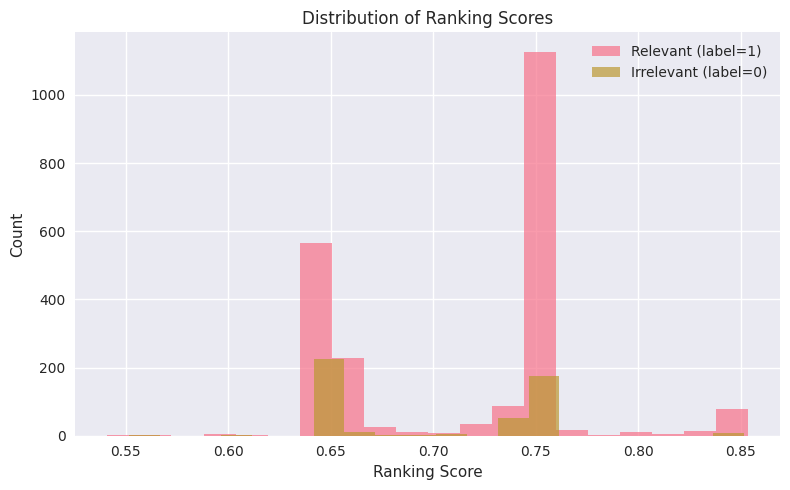


Evaluation Results:
Total users evaluated: 4986
Users with successful evaluation: 2189

Recall@K:
Recall@1: 0.1059
Recall@10: 0.1427
Recall@50: 0.1427
Recall@100: 0.1427

Precision@K:
Precision@1: 0.7218
Precision@10: 0.1012
Precision@50: 0.0202
Precision@100: 0.0101

NDCG@K:
NDCG@1: 0.7218
NDCG@10: 0.7555
NDCG@50: 0.7555
NDCG@100: 0.7555

MRR: 0.7486
Average Precision: 0.8533


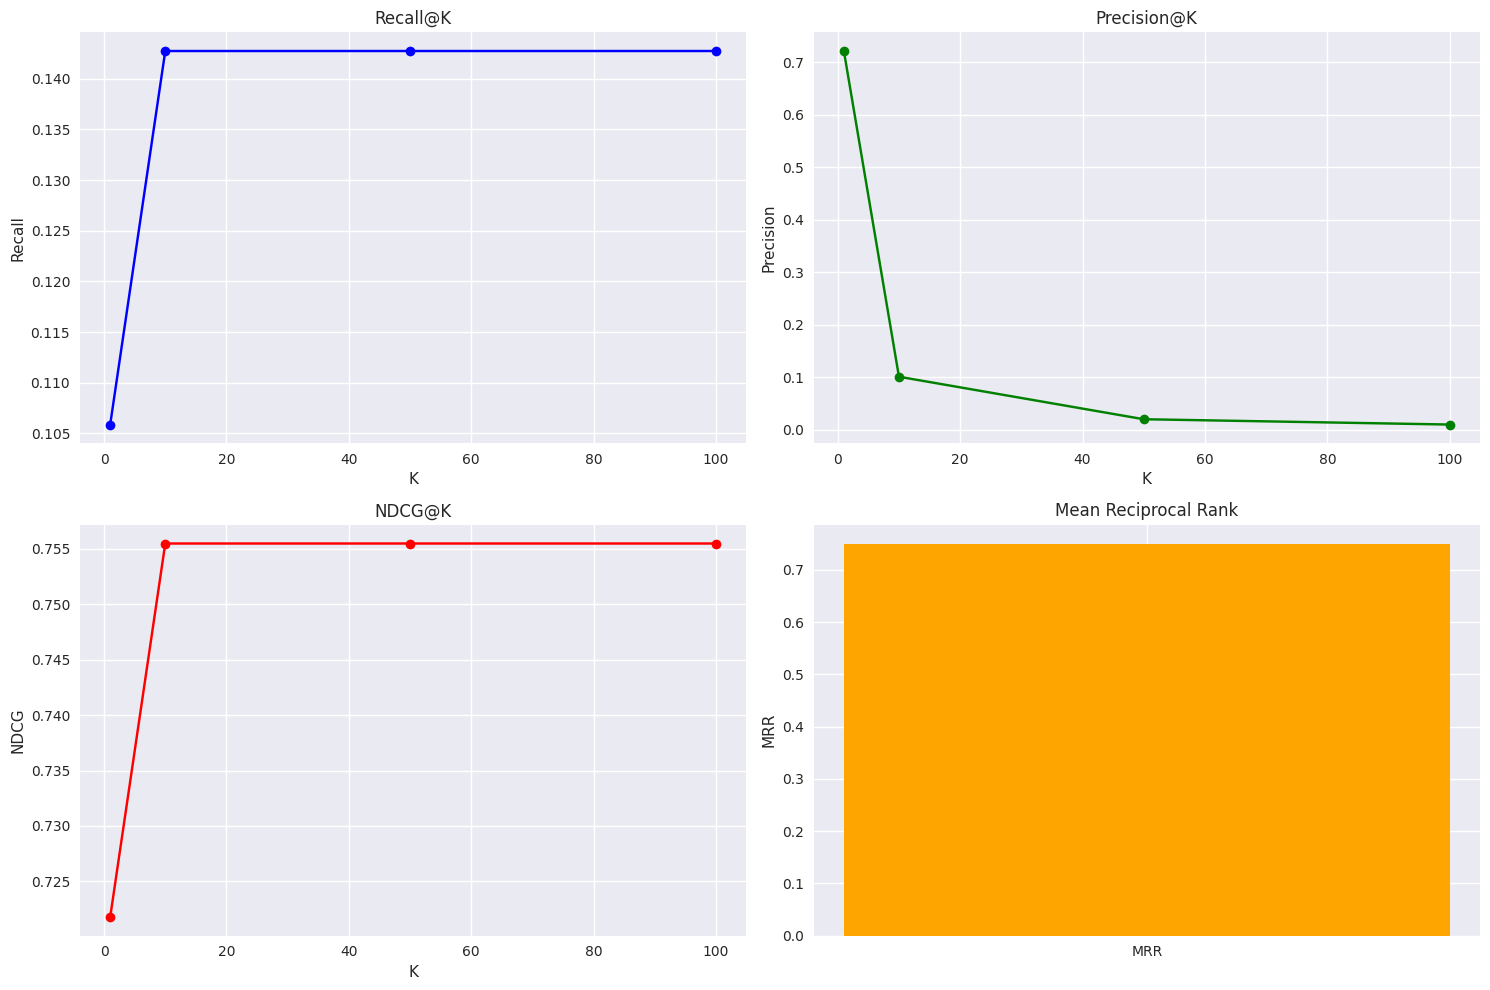

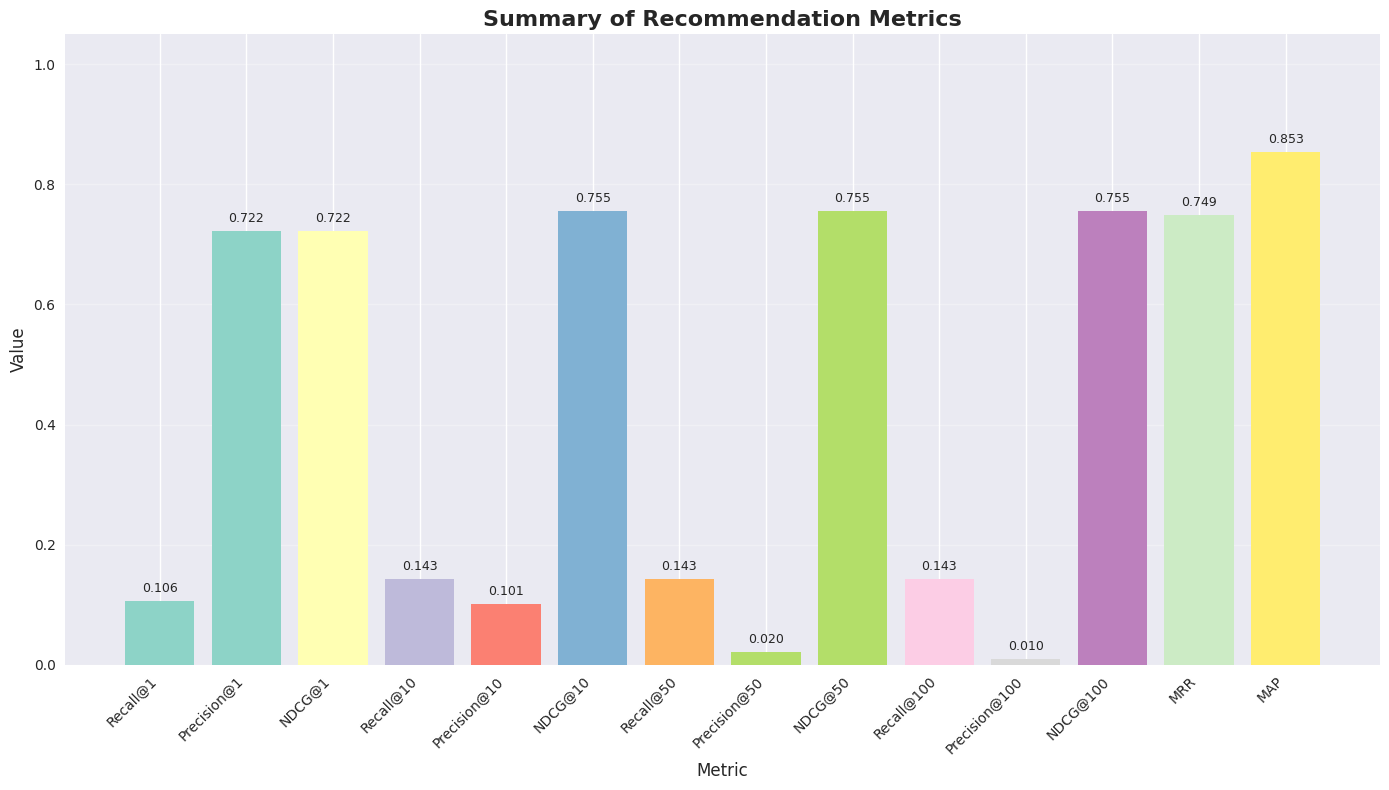


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully
Processed 400 users successfully
Processed 500 users successfully
Processed 600 users successfully
Processed 700 users successfully
Processed 800 users successfully
Processed 900 users successfully
Processed 1000 users successfully
Processed 1100 users successfully
Processed 1200 users successfully
Processed 1300 users successfully
Processed 1400 users successfully
Processed 1500 users successfully
Processed 1600 users successfully
Processed 1700 users successfully
Processed 1800 users successfully
Processed 1900 users successfully
Processed 2000 users successfully
Processed 2100 users successfully
Processed 2200 users successfully
Processed 2300 users successfully
Processed 2400 users successfully
Processed 2500 users successfully
Processed 2600 users successfull

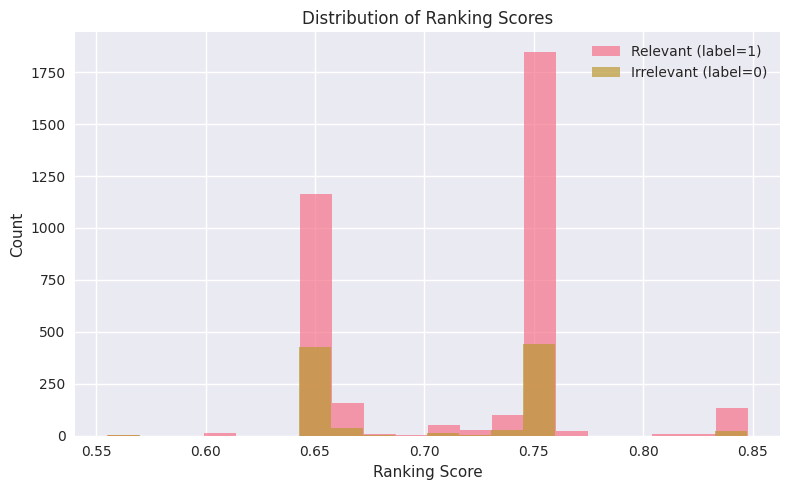


Evaluation Results:
Total users evaluated: 4986
Users with successful evaluation: 3132

Recall@K:
Recall@1: 0.1081
Recall@10: 0.1599
Recall@50: 0.1599
Recall@100: 0.1599

Precision@K:
Precision@1: 0.7273
Precision@10: 0.1133
Precision@50: 0.0227
Precision@100: 0.0113

NDCG@K:
NDCG@1: 0.7273
NDCG@10: 0.7738
NDCG@50: 0.7738
NDCG@100: 0.7738

MRR: 0.7643
Average Precision: 0.8108


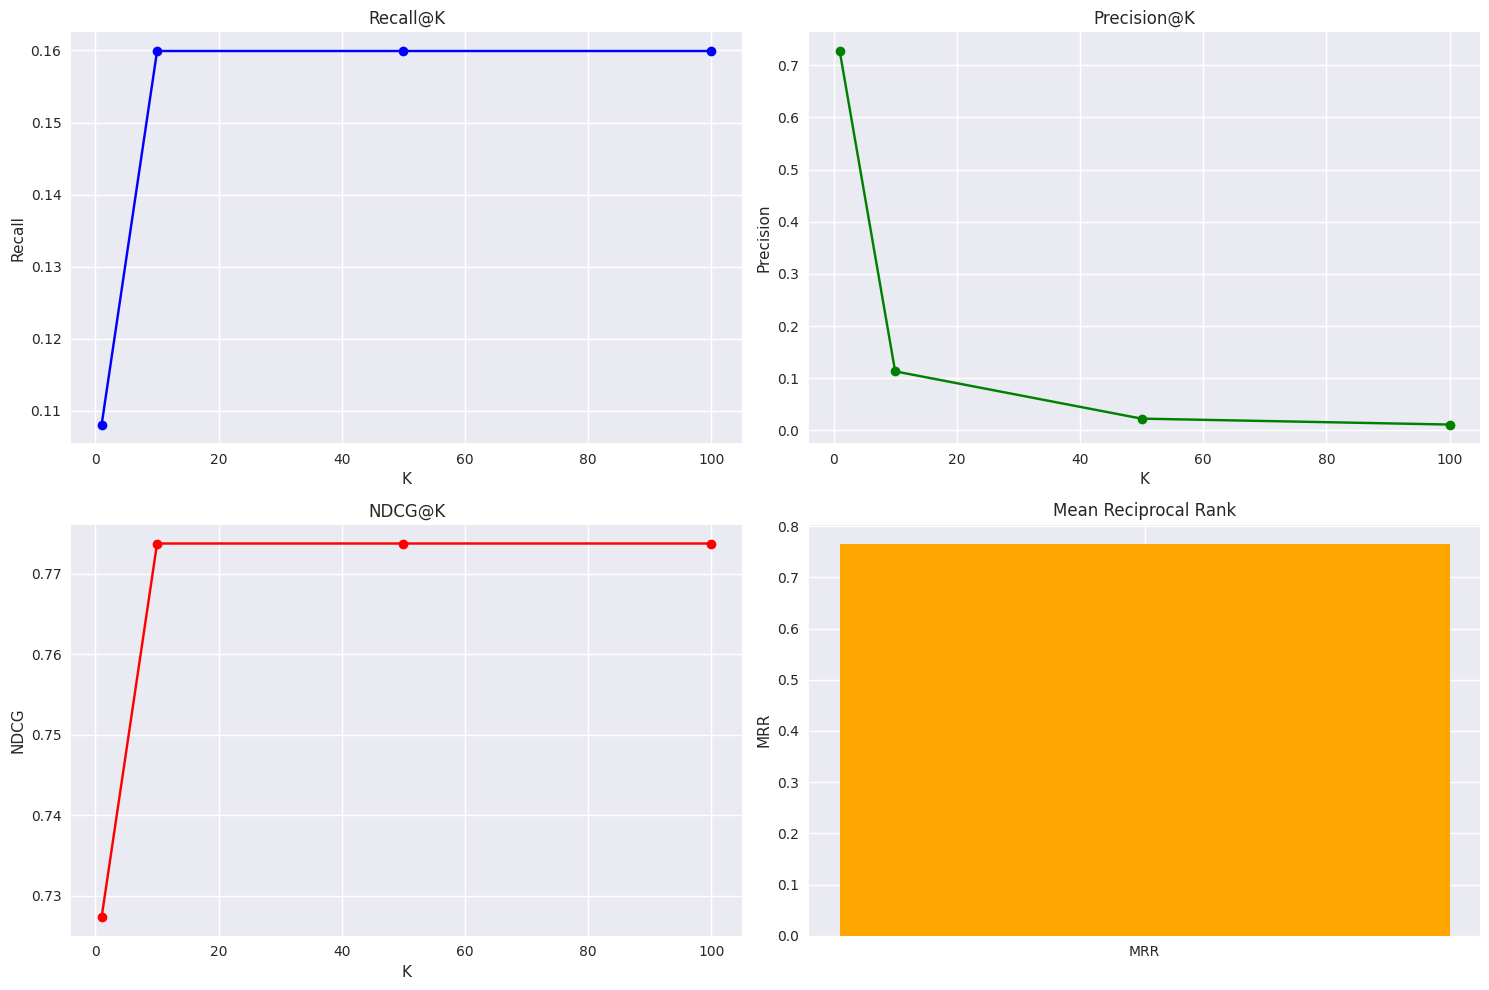

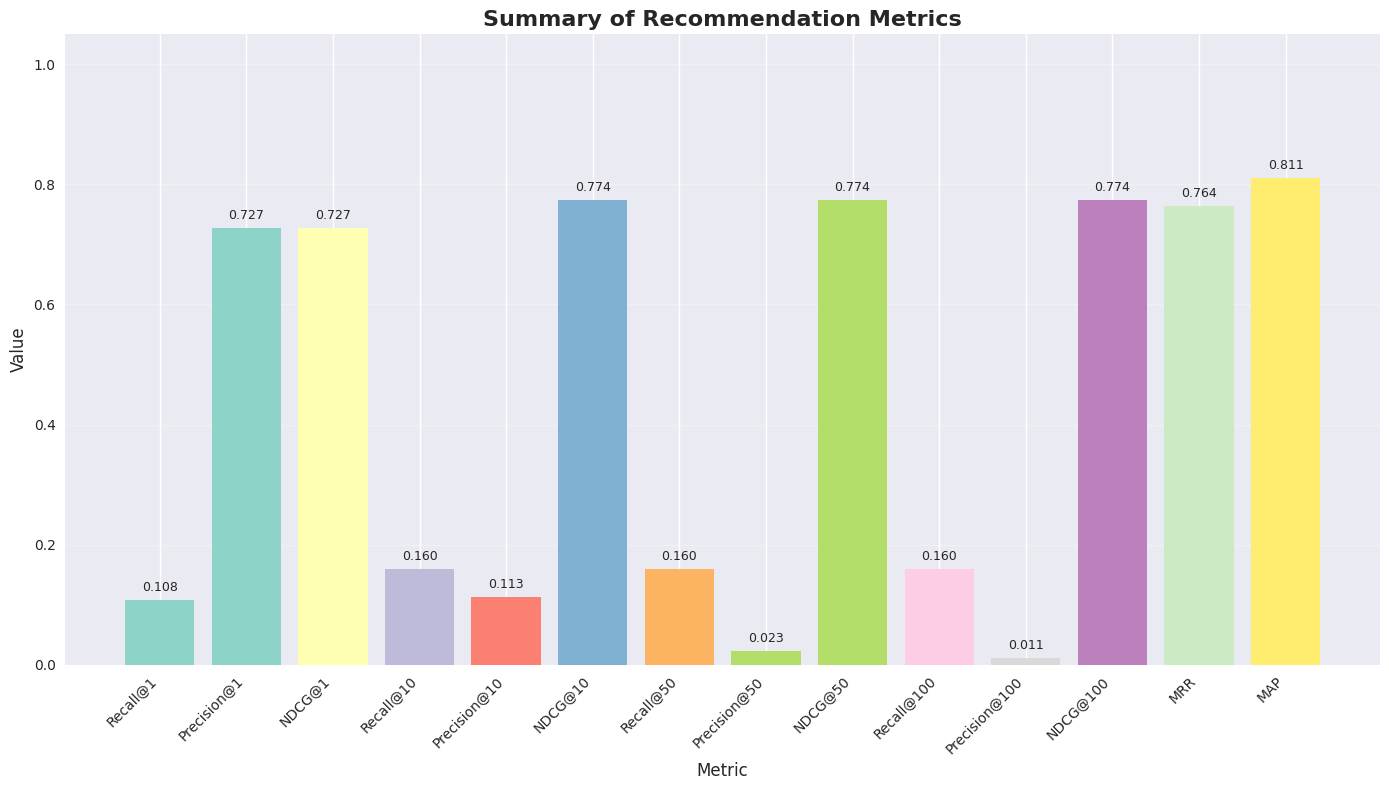


Comparison of Integrated Pipelines:
Weather Model MRR: 0.7486
No-Weather Model MRR: 0.7643
Weather features decrease MRR by 2.09%

Evaluation pipeline complete!

Results saved to CSV files:
- weather_model_results.csv
- no_weather_model_results.csv
- combined_retrieval_ranking_results.csv

Combined Results Summary:
     Model   k  Precision   Recall      MRR     NDCG  Coverage
   Weather   1   0.721791 0.105875 0.748630 0.721791  0.439029
   Weather  10   0.101233 0.142725 0.748630 0.755463  0.439029
   Weather  50   0.020247 0.142725 0.748630 0.755463  0.439029
   Weather 100   0.010123 0.142725 0.748630 0.755463  0.439029
No_Weather   1   0.727331 0.108082 0.764261 0.727331  0.628159
No_Weather  10   0.113282 0.159923 0.764261 0.773773  0.628159
No_Weather  50   0.022656 0.159923 0.764261 0.773773  0.628159
No_Weather 100   0.011328 0.159923 0.764261 0.773773  0.628159


In [ ]:
def main():
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Wednesday, May 14, 2025, 1:03 PM CEST")
    print("=" * 50)
    
    # Load models (replace with your actual model loading code)
    query_model = model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    cold_weather_df  = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        weather_model,
        cold_users_merged_df,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=True,
        filter_time=False
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    cold_no_weather_df  = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        no_weather_model,
        cold_users_merged_df,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,  # No weather filtering
        filter_time=False
    )
    
    print("\nComparison of Integrated Pipelines:")
    print(f"Weather Model MRR: {cold_weather_df['mrr']:.4f}")
    print(f"No-Weather Model MRR: {cold_no_weather_df['mrr']:.4f}")
    
    if cold_weather_df["mrr"] > cold_no_weather_df["mrr"]:
        improvement = ((cold_weather_df["mrr"] - cold_no_weather_df["mrr"]) / cold_no_weather_df["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        diff = ((cold_no_weather_df["mrr"] - cold_weather_df["mrr"]) / cold_weather_df["mrr"]) * 100
        print(f"Weather features decrease MRR by {diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")
    
    # Save results to CSV files
    cold_weather_df = cold_weather_df["results_dataframe"]
    cold_no_weather_df = cold_no_weather_df["results_dataframe"]
    
    # Add model type identifier
    cold_weather_df['Model'] = 'Weather'
    cold_no_weather_df['Model'] = 'No_Weather'

    
    # Combine results
    cold_combined_results = pd.concat([cold_weather_df, cold_no_weather_df], ignore_index=True)
    
    # Combine all (warm + cold)
# if cold_weather_df is not None and cold_no_weather_df is not None:
#     weather_df["Scenario"] = "Warm Start"
#     no_weather_df["Scenario"] = "Warm Start"
#     combined_full = pd.concat([weather_df, no_weather_df, cold_weather_df, cold_no_weather_df], ignore_index=True)
#     combined_full.to_csv("retrieval_ranking_warm_vs_cold.csv", index=False)
#     print("\nCombined (Warm + Cold) Results saved to retrieval_ranking_warm_vs_cold.csv")
    # Save individual and combined results
    cold_weather_df.to_csv("cold_user_weather_results.csv", index=False)
    cold_no_weather_df.to_csv("cold_user_no_weather_results.csv", index=False)
    cold_combined_results.to_csv("cold_user_combined_retrieval_ranking_results.csv", index=False)
    
    print("\nResults saved to CSV files:")
    print("- weather_model_results.csv")
    print("- no_weather_model_results.csv") 
    print("- combined_retrieval_ranking_results.csv")
    
    # Display the combined results
    print("\nCombined Results Summary:")
    print(cold_combined_results.to_string(index=False))
    
    return cold_weather_df, cold_no_weather_df, cold_combined_results

if __name__ == "__main__":
    main()

## Evaluation of Cold vs Warm Users

2025-06-27 08:42:06,193 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-27 08:42:06,210 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


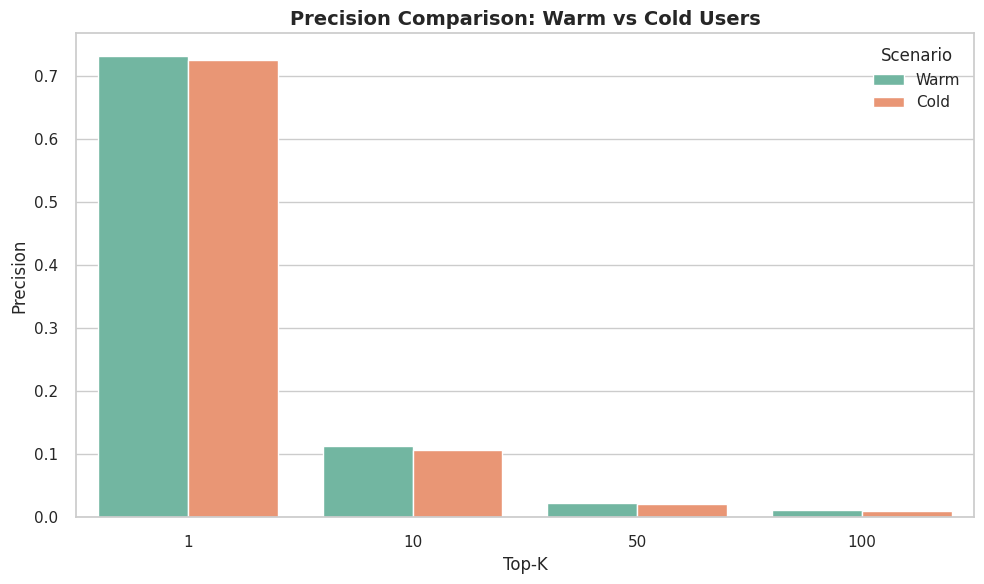

2025-06-27 08:42:06,880 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-27 08:42:06,894 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


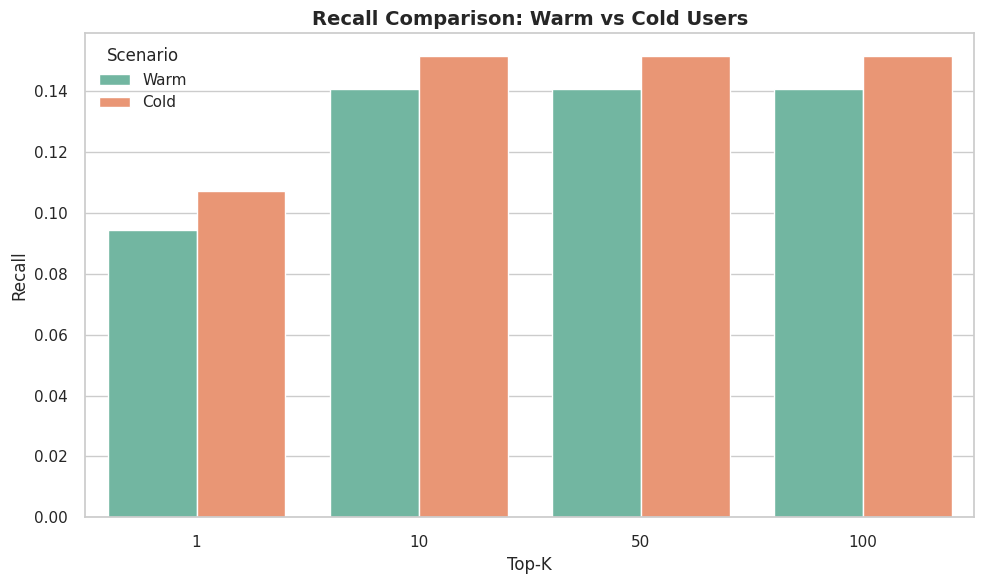

2025-06-27 08:42:07,751 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-27 08:42:07,762 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


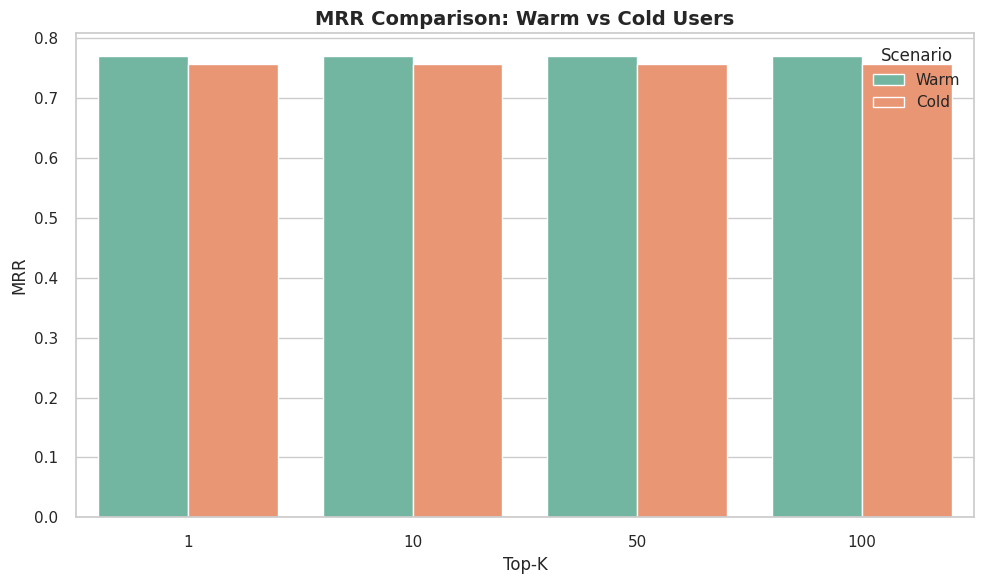

2025-06-27 08:42:08,415 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-27 08:42:08,434 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


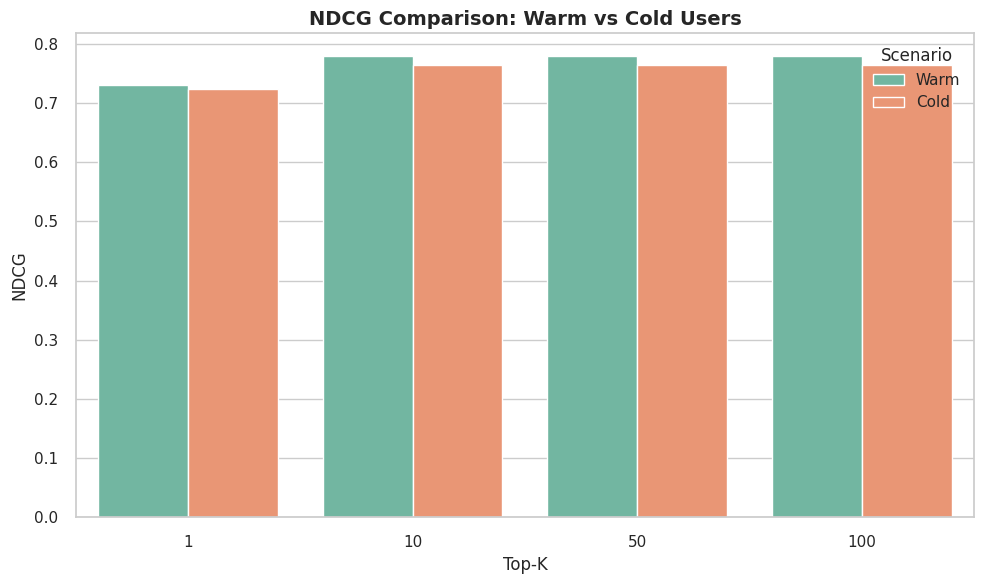

In [12]:
warm_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/notebooks/combined_retrieval_ranking_results.csv")
cold_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/notebooks/cold_user_combined_retrieval_ranking_results.csv")

warm_df["Scenario"] = "Warm"
cold_df["Scenario"] = "Cold"
combined_df = pd.concat([warm_df, cold_df], ignore_index=True)

# Plot Comparison
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

metrics = ["Precision", "Recall", "MRR", "NDCG"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=combined_df,
        x="k", y=metric,
        hue="Scenario", 
        ci=None,
        palette="Set2"
    )
    plt.title(f"{metric} Comparison: Warm vs Cold Users", fontsize=14, weight="bold")
    plt.xlabel("Top-K")
    plt.ylabel(metric)
    plt.legend(title="Scenario")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"comparison_{metric.lower()}_warm_vs_cold.png", dpi=300)
    plt.show()


In [13]:
combined_df

,Model,k,Precision,Recall,MRR,NDCG,Coverage,Scenario
0,Weather,1,0.734171,0.094216,0.764826,0.734171,0.477750,Warm
1,Weather,10,0.106750,0.131924,0.764826,0.771871,0.477750,Warm
2,Weather,50,0.021350,0.131924,0.764826,0.771871,0.477750,Warm
3,Weather,100,0.010675,0.131924,0.764826,0.771871,0.477750,Warm
4,No_Weather,1,0.726969,0.094652,0.773712,0.726969,0.673000,Warm
5,No_Weather,10,0.119428,0.149034,0.773712,0.785941,0.673000,Warm
6,No_Weather,50,0.023886,0.149034,0.773712,0.785941,0.673000,Warm
7,No_Weather,100,0.011943,0.149034,0.773712,0.785941,0.673000,Warm
8,Weather,1,0.721791,0.105875,0.748630,0.721791,0.439029,Cold
9,Weather,10,0.101233,0.142725,0.748630,0.755463,0.439029,Cold


In [47]:
combined_df.to_csv("two-tower_HotVsCold.csv")

## Evaluation with warm users without weather post-retrieval filtering

Starting evaluation pipeline for retrieval and ranking models...
Current date: Wednesday, May 14, 2025, 1:03 PM CEST

Evaluating Integrated Retrieval-Ranking Pipeline (Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully
Processed 400 users successfully
Processed 500 users successfully
Processed 600 users successfully
Processed 700 users successfully
Processed 800 users successfully
Processed 900 users successfully
Processed 1000 users successfully
Processed 1100 users successfully
Processed 1200 users successfully
Processed 1300 users successfully
Processed 1400 users successfully
Processed 1500 users successfully
Processed 1600 users successfully
Processed 1700 users successfully
Processed 1800 users successfully
Processed 1900 users successfully
Processed 2000 users successfully
Processed 2100 users successfully
Processed 2200 users successfully
Processed 2300 users

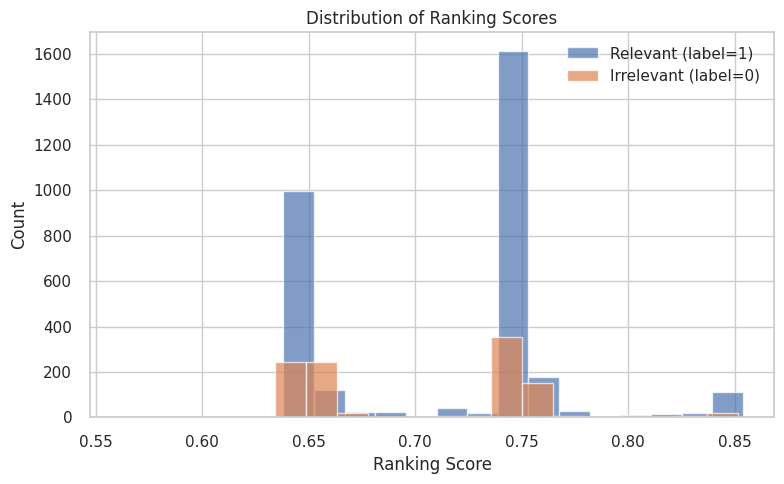


Evaluation Results:
Total users evaluated: 4000
Users with successful evaluation: 2692

Recall@K:
Recall@1: 0.0954
Recall@10: 0.1490
Recall@50: 0.1490
Recall@100: 0.1490

Precision@K:
Precision@1: 0.7333
Precision@10: 0.1194
Precision@50: 0.0239
Precision@100: 0.0119

NDCG@K:
NDCG@1: 0.7333
NDCG@10: 0.7878
NDCG@50: 0.7878
NDCG@100: 0.7878

MRR: 0.7770
Average Precision: 0.7949


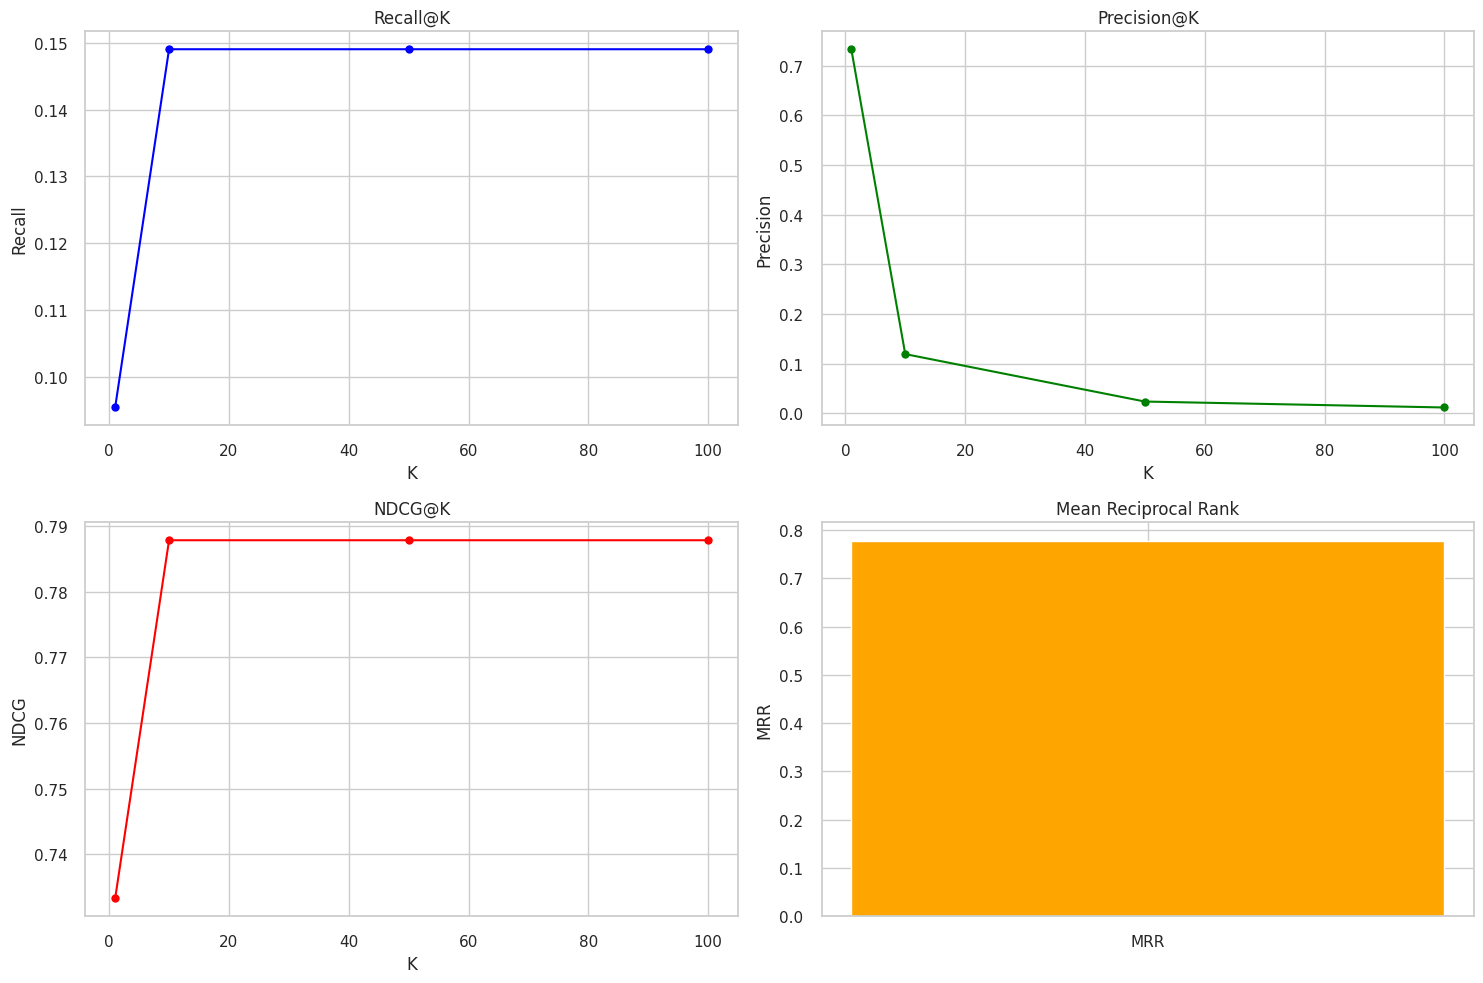

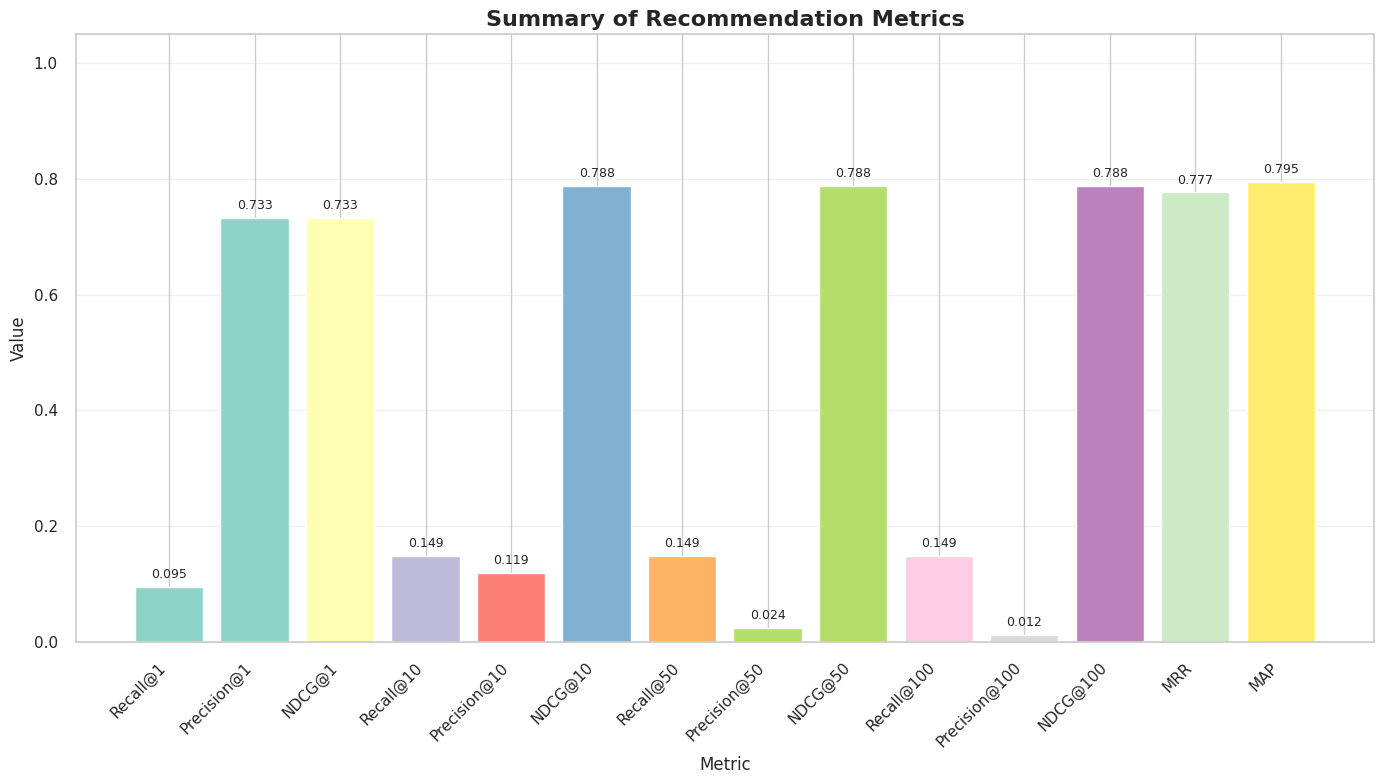


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully
Processed 400 users successfully
Processed 500 users successfully
Processed 600 users successfully
Processed 700 users successfully
Processed 800 users successfully
Processed 900 users successfully
Processed 1000 users successfully
Processed 1100 users successfully
Processed 1200 users successfully
Processed 1300 users successfully
Processed 1400 users successfully
Processed 1500 users successfully
Processed 1600 users successfully
Processed 1700 users successfully
Processed 1800 users successfully
Processed 1900 users successfully
Processed 2000 users successfully
Processed 2100 users successfully
Processed 2200 users successfully
Processed 2300 users successfully
Processed 2400 users successfully
Processed 2500 users successfully
Processed 2600 users successfull

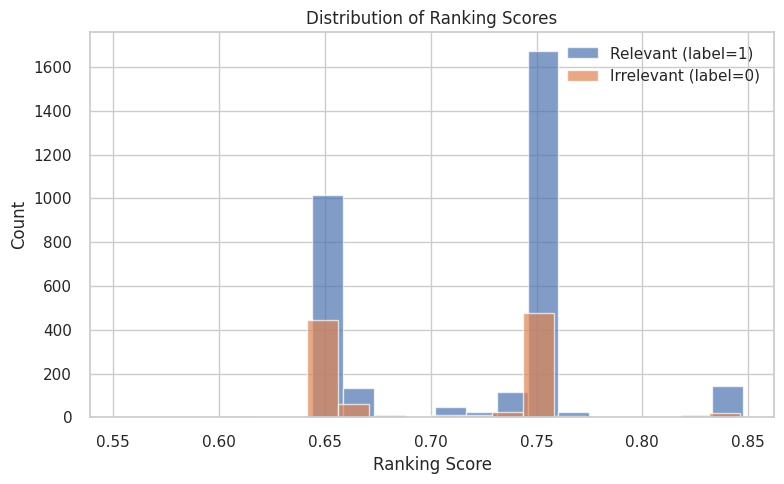


Evaluation Results:
Total users evaluated: 4000
Users with successful evaluation: 2692

Recall@K:
Recall@1: 0.0947
Recall@10: 0.1490
Recall@50: 0.1490
Recall@100: 0.1490

Precision@K:
Precision@1: 0.7270
Precision@10: 0.1194
Precision@50: 0.0239
Precision@100: 0.0119

NDCG@K:
NDCG@1: 0.7270
NDCG@10: 0.7859
NDCG@50: 0.7859
NDCG@100: 0.7859

MRR: 0.7737
Average Precision: 0.7897


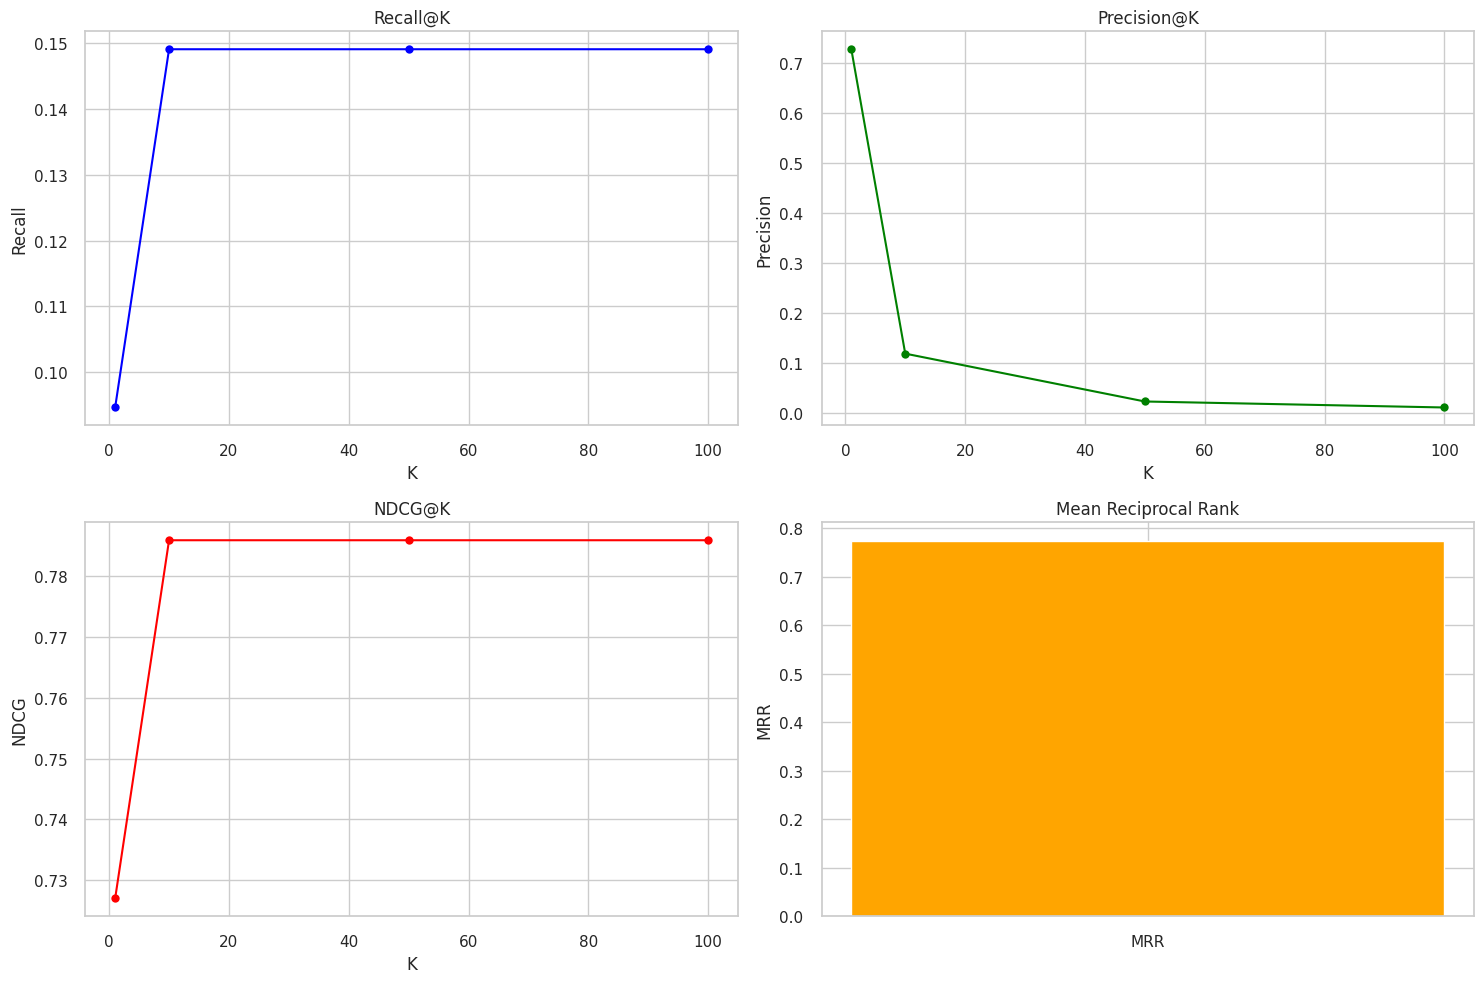

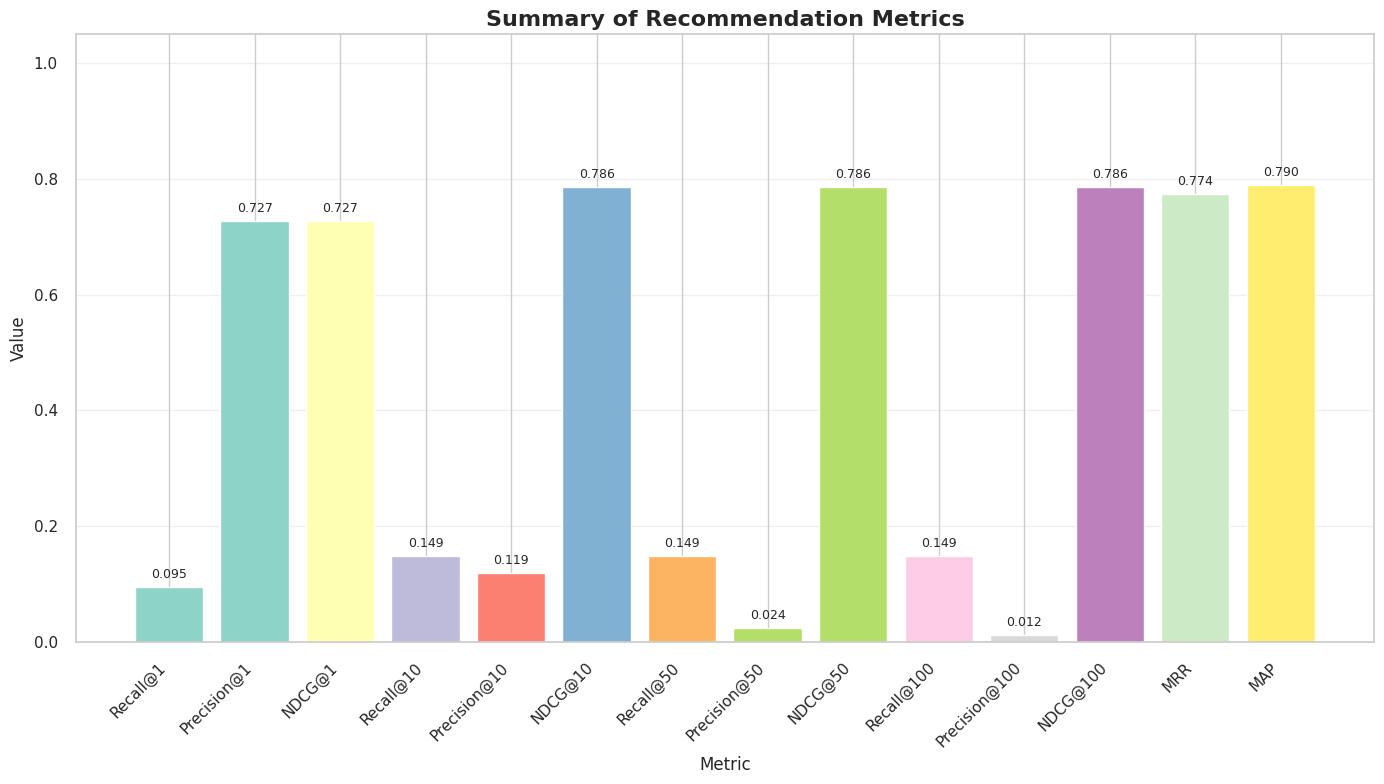


Comparison of Integrated Pipelines:
Weather Model MRR: 0.7770
No-Weather Model MRR: 0.7737
Weather features improve MRR by 0.42%

Evaluation pipeline complete!

Results saved to CSV files:
- weather_model_results.csv
- no_weather_model_results.csv
- combined_retrieval_ranking_results.csv

Combined Results Summary:
     Model   k  Precision   Recall      MRR     NDCG  Coverage
   Weather   1   0.733284 0.095368 0.776963 0.733284     0.673
   Weather  10   0.119428 0.149034 0.776963 0.787822     0.673
   Weather  50   0.023886 0.149034 0.776963 0.787822     0.673
   Weather 100   0.011943 0.149034 0.776963 0.787822     0.673
No_Weather   1   0.726969 0.094652 0.773712 0.726969     0.673
No_Weather  10   0.119428 0.149034 0.773712 0.785941     0.673
No_Weather  50   0.023886 0.149034 0.773712 0.785941     0.673
No_Weather 100   0.011943 0.149034 0.773712 0.785941     0.673


In [15]:
#
def main():
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Wednesday, May 14, 2025, 1:03 PM CEST")
    print("=" * 50)
    
    # Load models (replace with your actual model loading code)
    query_model = model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,
        filter_time=False
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        no_weather_model,
        test_interactions,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,  # No weather filtering
        filter_time=False
    )
    
    print("\nComparison of Integrated Pipelines:")
    print(f"Weather Model MRR: {weather_results['mrr']:.4f}")
    print(f"No-Weather Model MRR: {no_weather_results['mrr']:.4f}")
    
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        diff = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")
    
    # Save results to CSV files
    weather_df = weather_results["results_dataframe"]
    no_weather_df = no_weather_results["results_dataframe"]
    
    # Add model type identifier
    weather_df['Model'] = 'Weather'
    no_weather_df['Model'] = 'No_Weather'

    
    # Combine results
    combined_results = pd.concat([weather_df, no_weather_df], ignore_index=True)
    
    # # Save individual and combined results
    # weather_df.to_csv("no_filtering_weather_model_results.csv", index=False)
    # no_weather_df.to_csv("no_filtering_no_weather_model_results.csv", index=False)
    # combined_results.to_csv("no_filtering_combined_retrieval_ranking_results.csv", index=False)
    
    print("\nResults saved to CSV files:")
    print("- weather_model_results.csv")
    print("- no_weather_model_results.csv") 
    print("- combined_retrieval_ranking_results.csv")
    
    # Display the combined results
    print("\nCombined Results Summary:")
    print(combined_results.to_string(index=False))
    
    return weather_results, no_weather_results, combined_results

if __name__ == "__main__":
    main()

## Evaluation with semi-real-world data

In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier, Pool
import joblib
import math
from datetime import datetime

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- Data loading and renaming (as in your paste.txt) ---

# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/test_users_data.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/test_events_data.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/partially_synthetic/data/main_data/test_interactions_data.csv')
print(interactions_df.isnull().sum())

# Renaming columns in users_df
users_df.rename(columns={
    'lat': 'user_lat',
    'lng': 'user_lon',
    'location': 'user_city',
    'joinedAt': 'signup_date',

}, inplace=True)

# Renaming columns in events_df
events_df.rename(columns={
    'category': 'event_type',
    'lat': 'event_lat',
    'lng': 'event_lon',
    'city': 'event_city',
    'weather_description': 'weather_condition',
    'temperature_2m_mean': 'temperature'
}, inplace=True)

# Renaming columns in interactions_df
interactions_df.rename(columns={
    'distance_to_event': 'interaction_distance_to_event'
}, inplace=True)

def safe_id_convert(x):
    if x is None:
        return "unknown"
    if isinstance(x, float):
        if math.isnan(x):
            return "unknown"
        else:
            return str(int(x))
    try:
        return str(int(float(x)))
    except Exception:
        return "unknown"

# Apply safe conversion
users_df["user_id"] = users_df["user_id"].apply(safe_id_convert)
events_df["event_id"] = events_df["event_id"].apply(safe_id_convert)
interactions_df["user_id"] = interactions_df["user_id"].apply(safe_id_convert)
interactions_df["event_id"] = interactions_df["event_id"].apply(safe_id_convert)

# Remove rows with unknown IDs to avoid mismatches
users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

# Verify conversion
print("Sample user_id in interactions data after conversion:", interactions_df["user_id"].head().tolist())
print("Sample user_id in users data after conversion:", users_df["user_id"].head().tolist())

# Print the first few user IDs from each dataset to compare
print("\nFirst 10 user IDs in interactions_df:", sorted(list(interactions_df["user_id"].unique()))[:10])
print("First 10 user IDs in users_df:", sorted(list(users_df["user_id"].unique()))[:10])

# Check intersection properly
common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
print(f"Number of common users: {len(common_users)}")
print("First 10 common user IDs:", sorted(list(common_users))[:10])

# Filter interactions to only include users that exist in the users dataset
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
print(f"Filtered interactions with valid users: {len(interactions_df)}")

# Check intersection of event IDs
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
print(f"Number of common events: {len(common_events)}")
print("First 10 common event IDs:", sorted(list(common_events))[:10])

# Filter interactions to only include events that exist in the events dataset
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]
print(f"Filtered interactions with valid events: {len(interactions_df)}")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type"]

NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city','title',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city','title', 
       'weather_condition', 'temperature','precipitation', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'indoor_outdoor_preference',
       'age', 'user_interests','user_weather_condition', 'user_temperature',	'user_precipitation']



# Print data info
print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

merged_df = pd.merge(interactions_df, users_df, on='user_id')
merged_df = pd.merge(merged_df, events_df, on='event_id') 

# Split data for evaluation
test_interactions = merged_df.sample(frac=0.5, random_state=42)
print(events_df.columns)
print(users_df.columns)
print(interactions_df.columns)
print(test_interactions.columns)
print(f"Test interactions: {len(test_interactions)}")


Unnamed: 0                 0
user_id                    0
event_id                   0
interaction_type           0
distance_to_event          0
interaction_label          0
event_weather_condition    0
event_temperature          0
event_precipitation_sum    0
user_weather_condition     0
user_temperature           0
user_precipitation         0
dtype: int64
Sample user_id in interactions data after conversion: ['3468617687', '487910947', '2769572227', '2974942354', '3468617687']
Sample user_id in users data after conversion: ['3197468391', '1091720544', '3341263967', '1363661070', '3104149470']

First 10 user IDs in interactions_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
First 10 user IDs in users_df: ['1000957666', '1002026815', '1002319016', '1002366476', '1003737814', '1003911464', '1004675047', '1005100691', '1005787999', '1007165855']
Number of common users: 5315
First 10 common 

Starting evaluation pipeline for retrieval and ranking models...
Current date: Wednesday, May 14, 2025, 1:03 PM CEST

Evaluating Integrated Retrieval-Ranking Pipeline (Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully
Processed 400 users successfully
Processed 500 users successfully
Processed 600 users successfully
Processed 700 users successfully
Processed 800 users successfully
Processed 900 users successfully


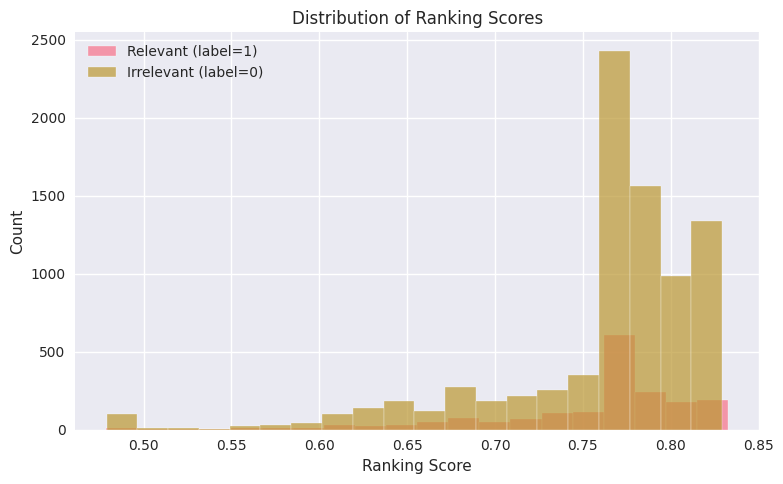


Evaluation Results:
Total users evaluated: 3562
Users with successful evaluation: 926

Recall@K:
Recall@1: 0.3166
Recall@10: 0.3884
Recall@50: 0.3952
Recall@100: 0.3954

Precision@K:
Precision@1: 0.5842
Precision@10: 0.1423
Precision@50: 0.0384
Precision@100: 0.0196

NDCG@K:
NDCG@1: 0.5842
NDCG@10: 0.7025
NDCG@50: 0.7037
NDCG@100: 0.7038

MRR: 0.6695
Average Precision: 0.1860


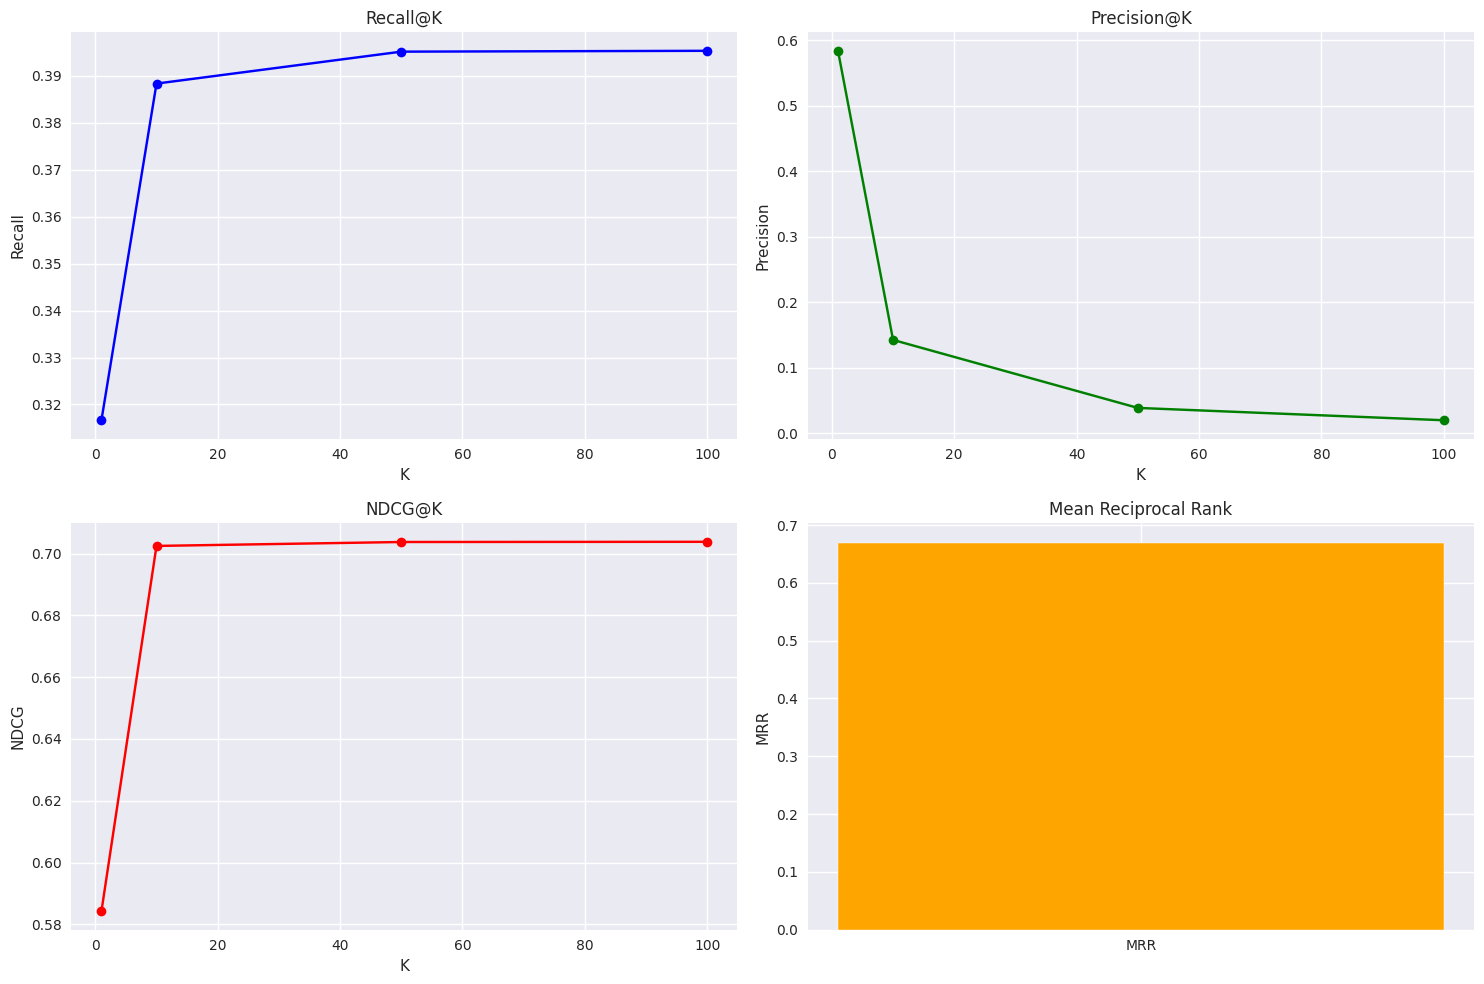

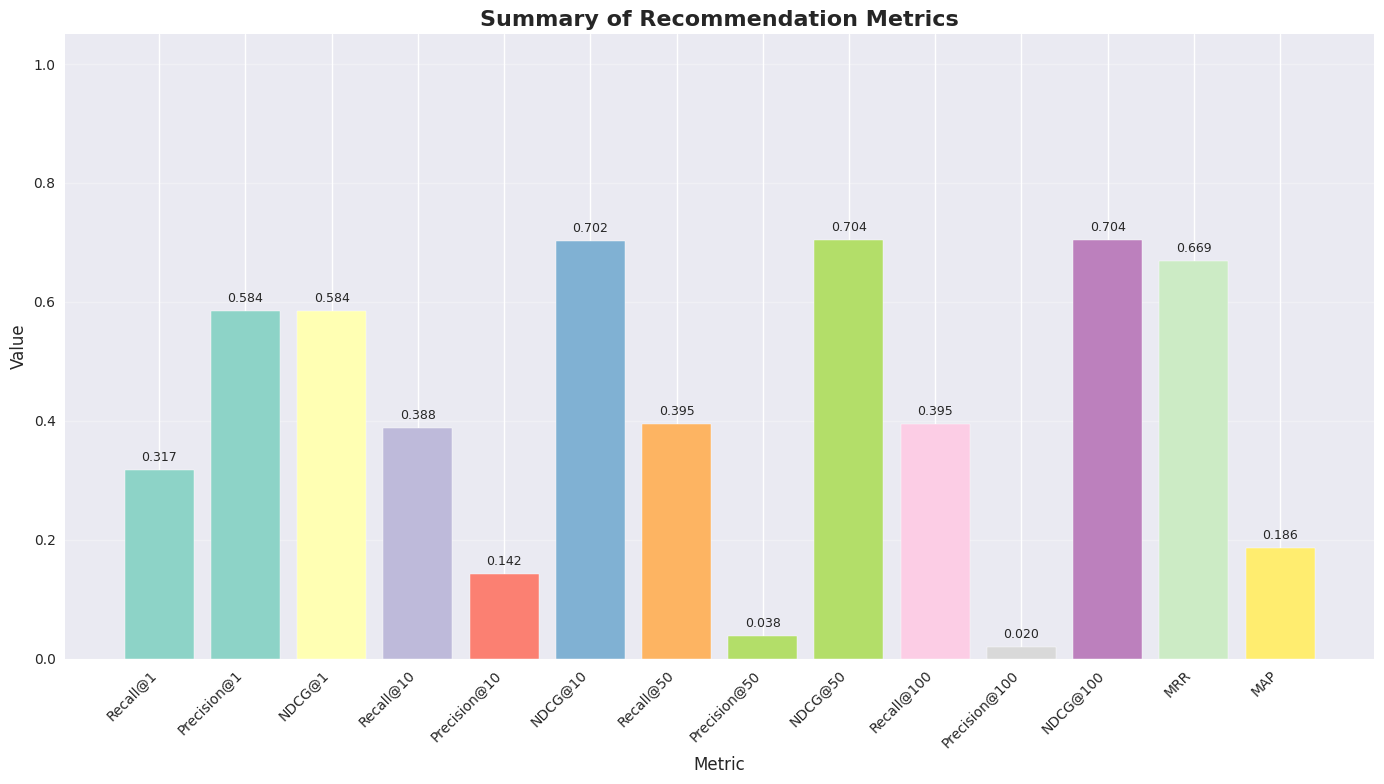


Evaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)

=== Evaluating Integrated Retrieval-Ranking Pipeline ===
Processed 100 users successfully
Processed 200 users successfully
Processed 300 users successfully
Processed 400 users successfully
Processed 500 users successfully
Processed 600 users successfully
Processed 700 users successfully
Processed 800 users successfully
Processed 900 users successfully
Processed 1000 users successfully
Processed 1100 users successfully
Processed 1200 users successfully
Processed 1300 users successfully


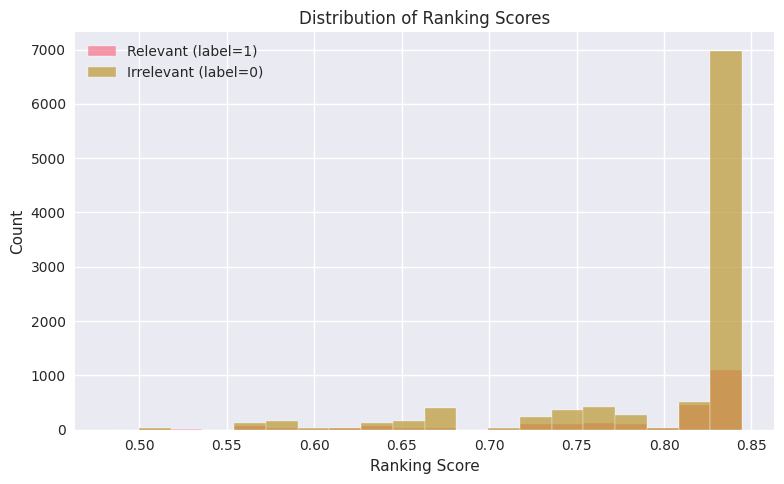


Evaluation Results:
Total users evaluated: 3562
Users with successful evaluation: 1335

Recall@K:
Recall@1: 0.3236
Recall@10: 0.4035
Recall@50: 0.4093
Recall@100: 0.4096

Precision@K:
Precision@1: 0.5820
Precision@10: 0.1285
Precision@50: 0.0338
Precision@100: 0.0173

NDCG@K:
NDCG@1: 0.5820
NDCG@10: 0.6831
NDCG@50: 0.6832
NDCG@100: 0.6832

MRR: 0.6570
Average Precision: 0.1390


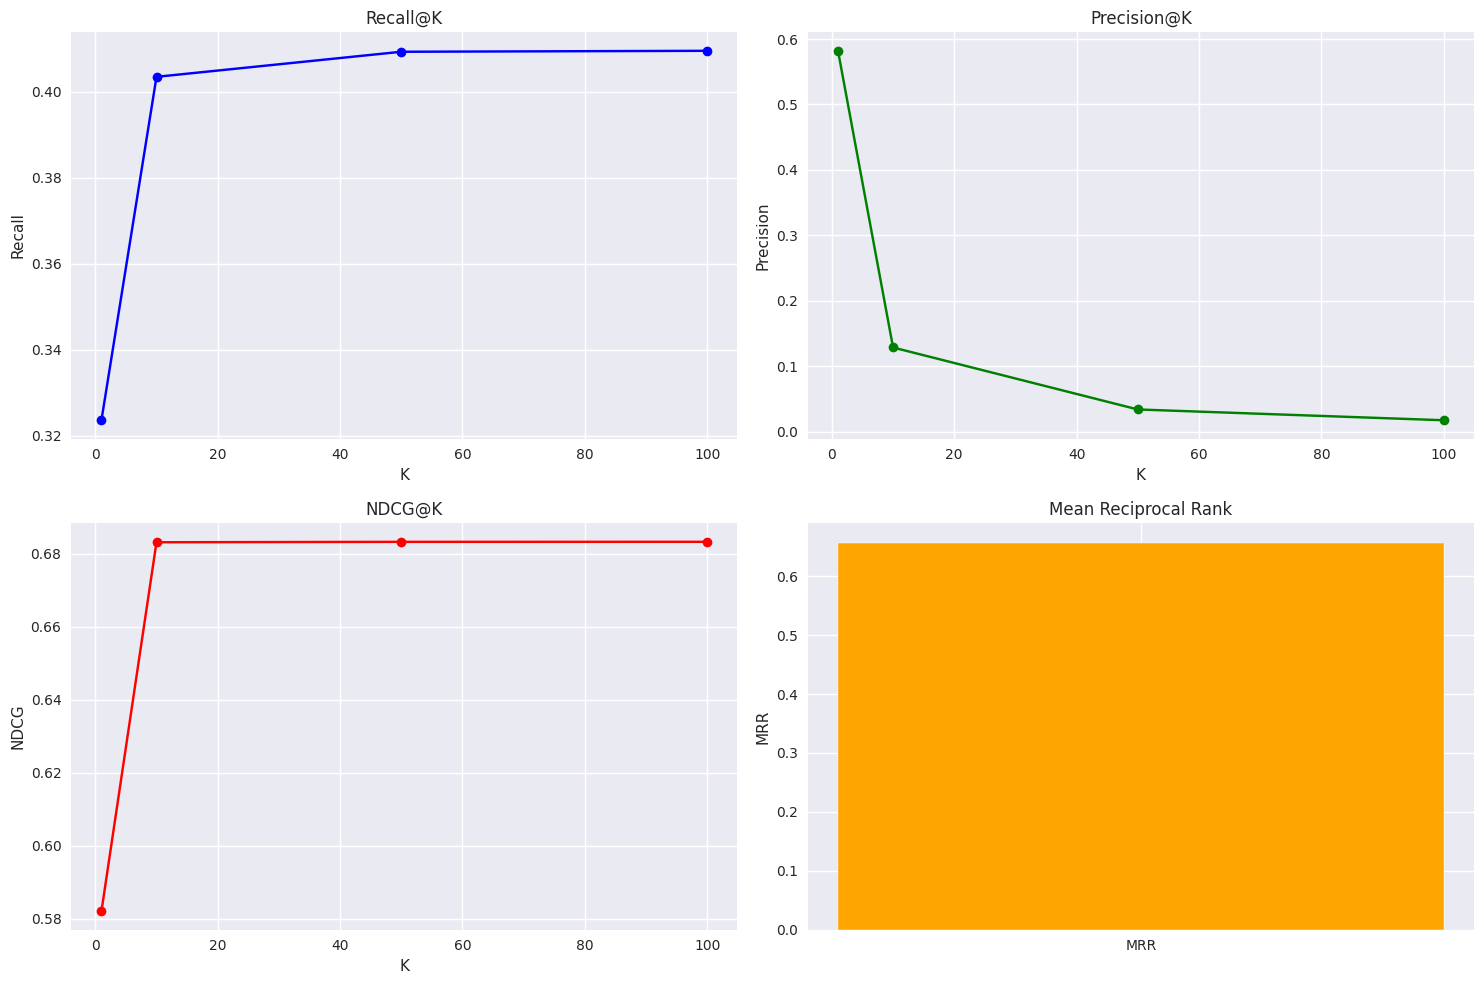

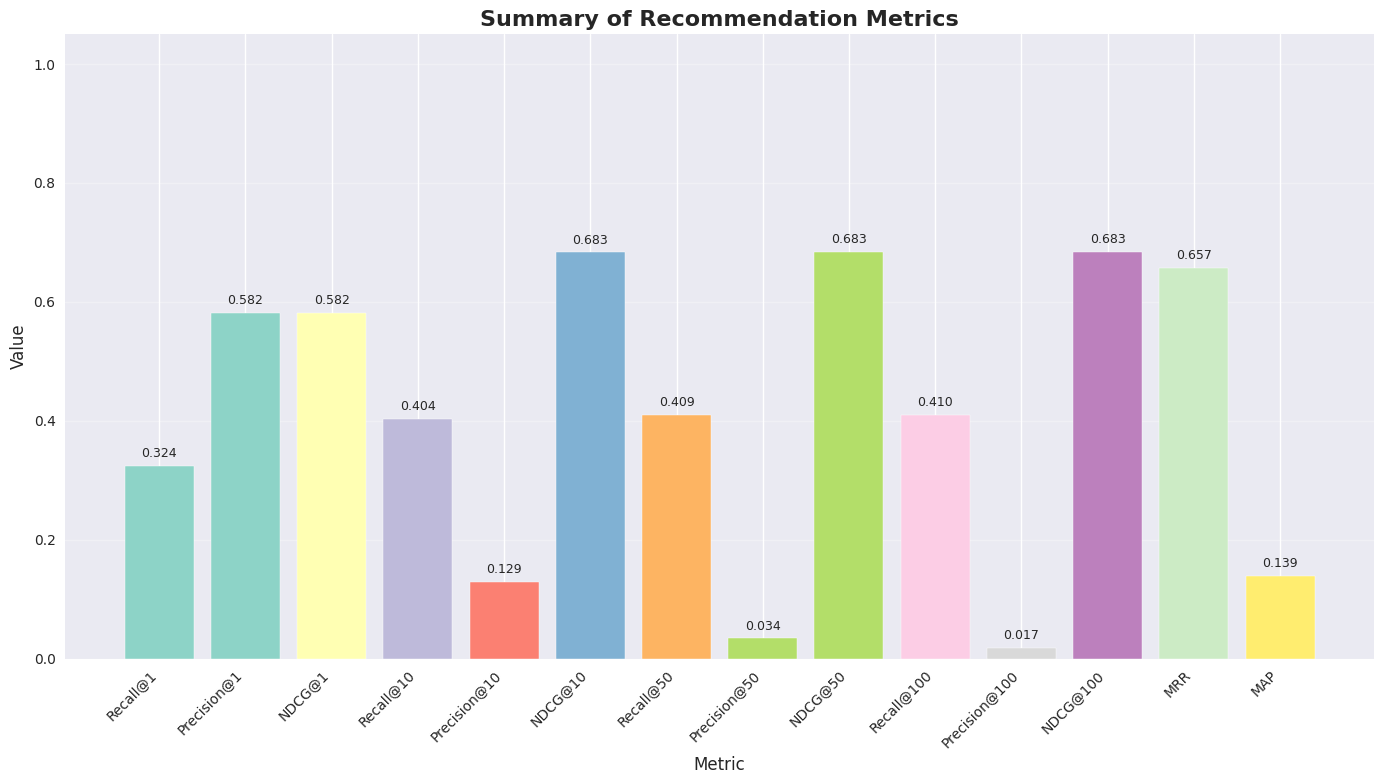


Comparison of Integrated Pipelines:
Weather Model MRR: 0.6695
No-Weather Model MRR: 0.6570
Weather features improve MRR by 1.90%

Evaluation pipeline complete!

semi_real_Combined Results Summary:
     Model   k  Precision   Recall      MRR     NDCG  Coverage
   Weather   1   0.584233 0.316642 0.669451 0.584233  0.259966
   Weather  10   0.142333 0.388368 0.669451 0.702463  0.259966
   Weather  50   0.038445 0.395172 0.669451 0.703731  0.259966
   Weather 100   0.019579 0.395353 0.669451 0.703795  0.259966
No_Weather   1   0.582022 0.323566 0.656974 0.582022  0.374789
No_Weather  10   0.128539 0.403506 0.656974 0.683094  0.374789
No_Weather  50   0.033828 0.409339 0.656974 0.683206  0.374789
No_Weather 100   0.017333 0.409563 0.656974 0.683217  0.374789


In [18]:

def main():
    print("Starting evaluation pipeline for retrieval and ranking models...")
    print(f"Current date: Wednesday, May 14, 2025, 1:03 PM CEST")
    print("=" * 50)
    
    # Load models (replace with your actual model loading code)
    query_model = model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (Weather Model)")
    weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=True,
        filter_time=False
    )
    
    print("\nEvaluating Integrated Retrieval-Ranking Pipeline (No-Weather Model)")
    no_weather_results = integrated_retrieval_ranking_pipeline(
        query_model,
        candidate_model,
        no_weather_model,
        test_interactions,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        max_k=100,
        filter_weather=False,  # No weather filtering
        filter_time=False
    )
    
    print("\nComparison of Integrated Pipelines:")
    print(f"Weather Model MRR: {weather_results['mrr']:.4f}")
    print(f"No-Weather Model MRR: {no_weather_results['mrr']:.4f}")
    
    if weather_results["mrr"] > no_weather_results["mrr"]:
        improvement = ((weather_results["mrr"] - no_weather_results["mrr"]) / no_weather_results["mrr"]) * 100
        print(f"Weather features improve MRR by {improvement:.2f}%")
    else:
        diff = ((no_weather_results["mrr"] - weather_results["mrr"]) / weather_results["mrr"]) * 100
        print(f"Weather features decrease MRR by {diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")
    
    # Save results to CSV files
    weather_df = weather_results["results_dataframe"]
    no_weather_df = no_weather_results["results_dataframe"]
    
    # Add model type identifier
    weather_df['Model'] = 'Weather'
    no_weather_df['Model'] = 'No_Weather'

    
    # Combine results
    combined_results = pd.concat([weather_df, no_weather_df], ignore_index=True)
    
    # Save individual and combined results
    weather_df.to_csv("semi_real_weather_model_results.csv", index=False)
    no_weather_df.to_csv("semi_real_no_weather_model_results.csv", index=False)
    combined_results.to_csv("semi_real_combined_retrieval_ranking_results.csv", index=False)
    
    
    # Display the combined results
    print("\nsemi_real_Combined Results Summary:")
    print(combined_results.to_string(index=False))

    
    return weather_results, no_weather_results, combined_results

if __name__ == "__main__":
    main()

## updated relevance logic to include attended and interest match

Users: 50000, Events: 10000, Interactions: 500000
Unique users: 49914
Unique events: 9999
Test interactions: 39911
Sample user_id in interactions data after conversion: ['DK924U', 'PQ743E', 'NX067Y', 'AJ787D', 'TA859C']
Sample user_id in users data after conversion: ['EJ688Y', 'RA189K', 'GM435P', 'QS920O', 'WU134L']

First 10 user IDs in interactions_df: ['AA048W', 'AA052G', 'AA067T', 'AA108M', 'AA123D', 'AA128J', 'AA138Q', 'AA154P', 'AA164C', 'AA168Y']
First 10 user IDs in users_df: ['AA048W', 'AA052G', 'AA067T', 'AA108M', 'AA123D', 'AA128J', 'AA138Q', 'AA154P', 'AA164C', 'AA168Y']
Number of common users: 49914
First 10 common user IDs: ['AA048W', 'AA052G', 'AA067T', 'AA108M', 'AA123D', 'AA128J', 'AA138Q', 'AA154P', 'AA164C', 'AA168Y']
Filtered interactions with valid users: 500000
Number of common events: 9999
First 10 common event IDs: ['AA293J', 'AA319O', 'AA359E', 'AA476F', 'AA535Z', 'AA644T', 'AA704L', 'AA756J', 'AA768X', 'AA960K']
Filtered interactions with valid events: 500000


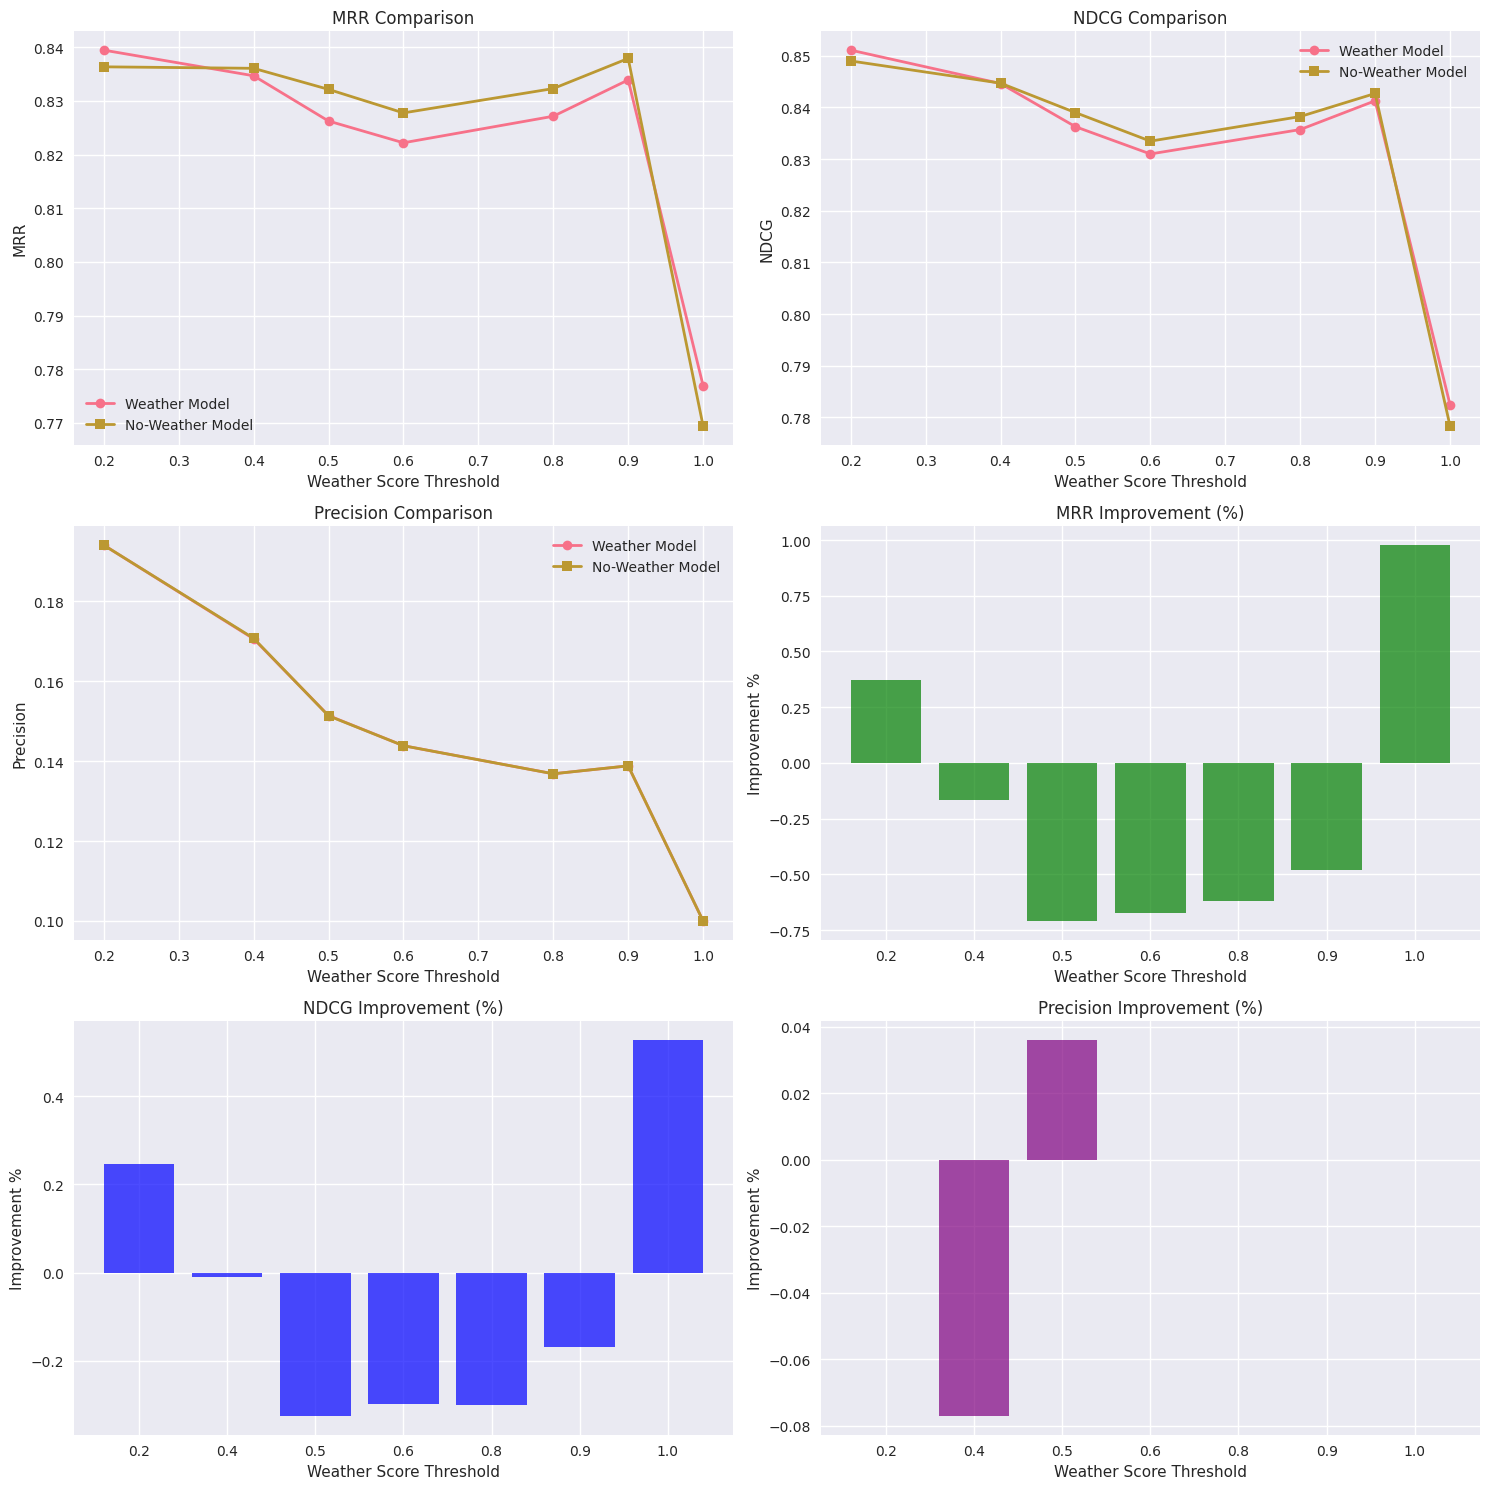

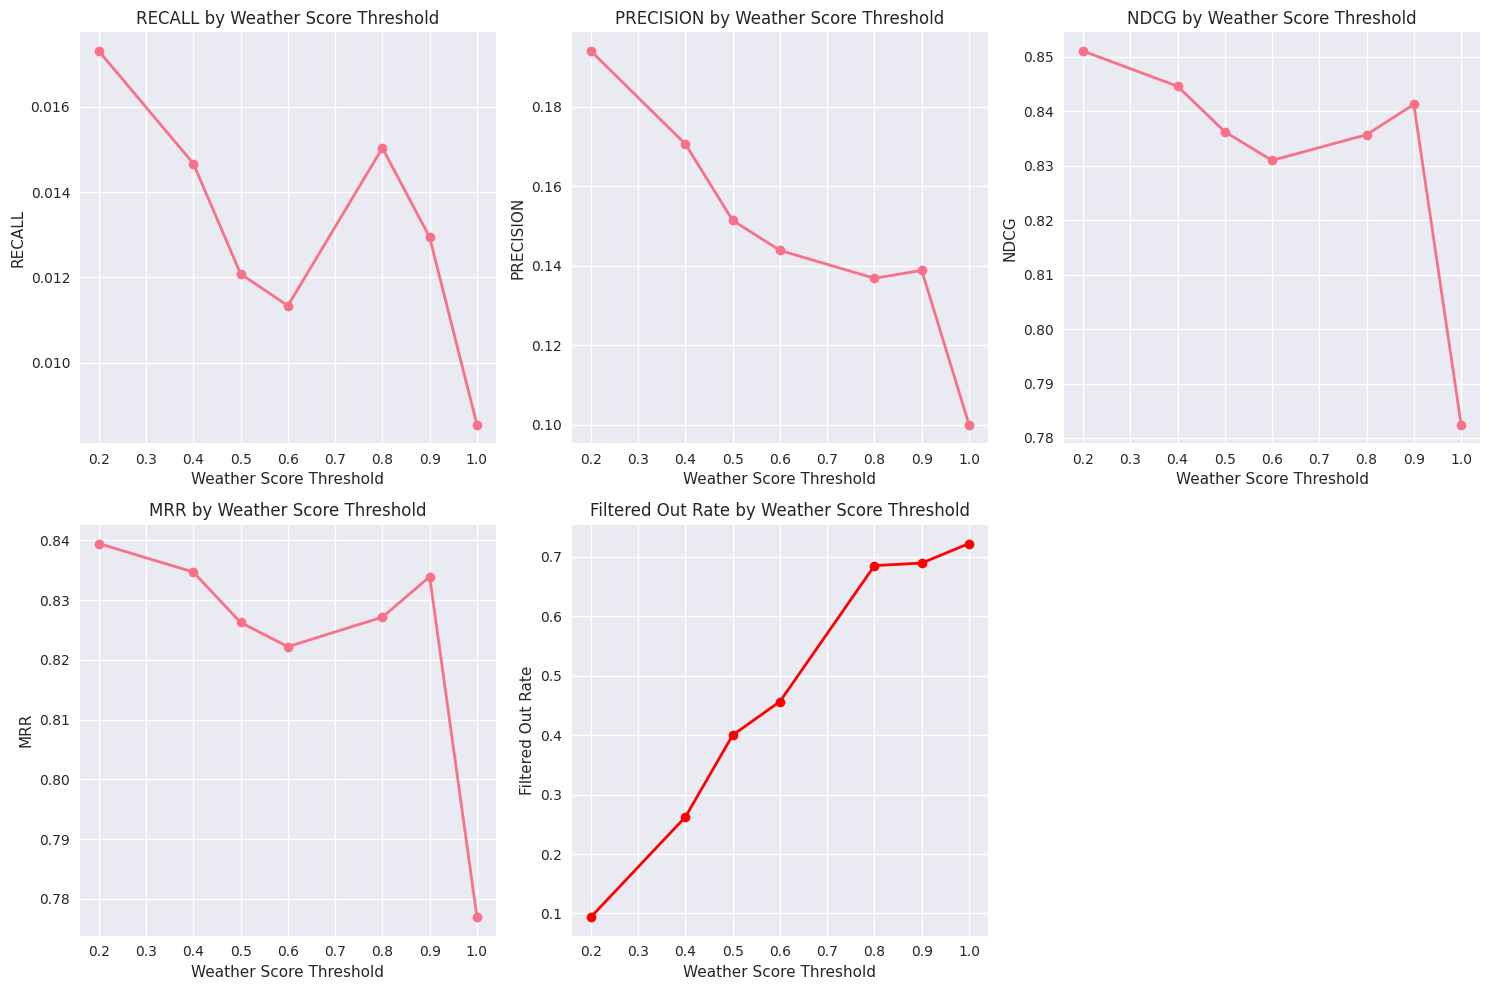

Weather features decrease MRR by 0.20%
Weather features decrease NDCG by 0.05%
Weather features decrease Precision by 0.01%

Evaluation pipeline complete!


In [63]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from catboost import CatBoostClassifier, Pool
import joblib
import math
from datetime import datetime

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- Data loading and renaming  ---
# Load data
users_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/users.csv')
events_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/events.csv")
interactions_df = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/interactions.csv')
events_df.rename(columns={
    'category': 'event_type',
}, inplace=True)

#test_users = test_df["user_id"].unique()
test_users = users_df["user_id"].unique()[:4000]
users_df = users_df[users_df["user_id"] != "unknown"]
events_df = events_df[events_df["event_id"] != "unknown"]
interactions_df = interactions_df[
    (interactions_df["user_id"] != "unknown") & (interactions_df["event_id"] != "unknown")
]

common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]


print(f"Users: {len(users_df)}, Events: {len(events_df)}, Interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique events: {interactions_df['event_id'].nunique()}")

merged_df = pd.merge(interactions_df, users_df, on='user_id')
merged_df = pd.merge(merged_df, events_df, on='event_id')
test_interactions = merged_df[merged_df["user_id"].isin(test_users)].sample(frac=1.0, random_state=42)
print(f"Test interactions: {len(test_interactions)}")

# Verify conversion
print("Sample user_id in interactions data after conversion:", interactions_df["user_id"].head().tolist())
print("Sample user_id in users data after conversion:", users_df["user_id"].head().tolist())

# Print the first few user IDs from each dataset to compare
print("\nFirst 10 user IDs in interactions_df:", sorted(list(interactions_df["user_id"].unique()))[:10])
print("First 10 user IDs in users_df:", sorted(list(users_df["user_id"].unique()))[:10])

# Check intersection properly
common_users = set(interactions_df["user_id"]).intersection(set(users_df["user_id"]))
print(f"Number of common users: {len(common_users)}")
print("First 10 common user IDs:", sorted(list(common_users))[:10])

# Filter interactions to only include users that exist in the users dataset
interactions_df = interactions_df[interactions_df["user_id"].isin(common_users)]
print(f"Filtered interactions with valid users: {len(interactions_df)}")

# Check intersection of event IDs
common_events = set(interactions_df["event_id"]).intersection(set(events_df["event_id"]))
print(f"Number of common events: {len(common_events)}")
print("First 10 common event IDs:", sorted(list(common_events))[:10])

# Filter interactions to only include events that exist in the events dataset
interactions_df = interactions_df[interactions_df["event_id"].isin(common_events)]
print(f"Filtered interactions with valid events: {len(interactions_df)}")

# Define feature sets
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type"]

NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city','title',
       'attendance_rate', 'event_indoor_capability', 'user_city', 'age',
       'user_interests']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event', 'event_type', 'event_city','title', 
       'weather_condition', 'temperature','precipitation', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'indoor_outdoor_preference',
       'age', 'user_interests','user_weather_condition', 'user_temperature',	'user_precipitation']





# --- Helper functions ---

def get_user_embeddings(query_model, user_ids):
    batch_users = users_df[users_df['user_id'].isin(user_ids)]
    if batch_users.empty:
        print(f"Warning: No users found for IDs: {user_ids}")
        return None
    batch_input = {
        "user_id": tf.constant(batch_users['user_id'].values),
        "user_city": tf.constant(batch_users['user_city'].values),
        "age": tf.constant(batch_users['age'].values, dtype=tf.float32),
        "user_interests": tf.constant(batch_users['user_interests'].values)
    }
    return query_model(batch_input).numpy()

def get_event_embeddings(candidate_model, events_data=None):
    if events_data is None:
        events_data = events_df.copy()
    events_dataset = tf.data.Dataset.from_tensor_slices({
        "event_id": tf.constant(events_data["event_id"].values),
        "event_city": tf.constant(events_data["event_city"].values),
        "event_type": tf.constant(events_data["event_type"].values),
        "title": tf.constant(events_data["title"].values)
    }).batch(128)
    event_ids = []
    event_embeddings = []
    for batch in events_dataset:
        batch_embeddings = candidate_model(batch)
        event_ids.extend(batch["event_id"].numpy())
        event_embeddings.append(batch_embeddings.numpy())
    return np.vstack(event_embeddings), event_ids

def build_faiss_index(embeddings):
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    return index

# --- Robust weather match scoring ---

def compute_weather_match(user_weather, event_weather, user_pref, event_type_val, user_temp, event_temp, user_precip, event_precip):
    score = 0.0
    # Weather group match (0.4)
    if user_weather == event_weather:
        score += 0.4
    elif (user_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy'] and event_weather in ['Sunny', 'Cloudy', 'Clear', 'Partly Cloudy']):
        score += 0.2
    elif (user_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm'] and event_weather in ['Rain', 'Light Drizzle', 'Heavy Rain', 'Thunderstorm']):
        score += 0.2
    # Indoor/outdoor preference match (0.3)
    if user_pref == 'any':
        score += 0.3
    elif (user_pref == 'indoor' and event_type_val in ['Indoor', 'Hybrid']) or (user_pref == 'outdoor' and event_type_val in ['Outdoor', 'Hybrid']):
        score += 0.3
    # Temperature and precipitation compatibility (0.3)
    temp_diff = abs(user_temp - event_temp)
    precip_diff = abs(user_precip - event_precip)
    temp_score = max(0, 1 - (temp_diff / 20))
    precip_score = max(0, 1 - (precip_diff / 10))
    score += 0.3 * (0.6 * temp_score + 0.4 * precip_score)
    return round(score, 2)

def post_retrieval_filtering(candidates_df, user_context, filter_weather=True, filter_time=True, max_distance_km=5000, weather_score_threshold=0.5):
    if filter_time and 'start_time' in candidates_df.columns:
        now = pd.Timestamp.now(tz='UTC')
        candidates_df = candidates_df[
            pd.to_datetime(candidates_df['start_time'], utc=True) > now
        ]
    # Location proximity filtering
    if 'interaction_distance_to_event' in candidates_df.columns:
        candidates_df = candidates_df[candidates_df['interaction_distance_to_event'] <= max_distance_km]
    
    # Weather filtering
    if filter_weather:
        scores = []
        for _, event in candidates_df.iterrows():
            score = compute_weather_match(
                user_context.get('user_weather_condition', 'any'),
                event.get('weather_condition', 'unknown'),
                user_context.get('indoor_outdoor_preference', 'any'),
                event.get('event_type', 'unknown'),
                user_context.get('user_temperature', 20),
                event.get('temperature', 20),
                user_context.get('user_precipitation', 0),
                event.get('precipitation_sum', 0)
            )
            scores.append(score)
        candidates_df = candidates_df.assign(weather_match_score=scores)
        candidates_df = candidates_df[candidates_df['weather_match_score'] >= weather_score_threshold]
    return candidates_df

# --- Main retrieval-ranking pipeline with filtering ---

def evaluate_weather_thresholds_comparison(
    query_model, candidate_model, weather_model, no_weather_model, test_interactions, 
    weather_features, no_weather_features, 
    k_retrieval=100, k=10, filter_time=True, max_distance_km=5000, 
    weather_score_thresholds=[0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0]
):
    print("\n=== Comparing Weather vs No-Weather Models Across Thresholds ===")
    event_embeddings, event_ids_bytes = get_event_embeddings(candidate_model)
    event_ids = [eid.decode('utf-8') if isinstance(eid, bytes) else str(eid) for eid in event_ids_bytes]
    faiss_index = build_faiss_index(event_embeddings)
    
    # Initialize metrics storage for each threshold
    weather_results = {
        threshold: {
            "recall": [],
            "precision": [],
            "ndcg": [],
            "mrr": [],
            "total_users": 0,
            "successful_users": 0,
            "filtered_out_rate": []
        }
        for threshold in weather_score_thresholds
    }
    
    no_weather_results = {
        threshold: {
            "recall": [],
            "precision": [],
            "ndcg": [],
            "mrr": [],
            "total_users": 0,
            "successful_users": 0
        }
        for threshold in weather_score_thresholds
    }
    
    user_groups = test_interactions.groupby('user_id')
    total_users = 0
    
    for user_id, group in user_groups:
        try:
            total_users += 1
            
            # Get ground truth events the user actually interacted with
            attended_events = set(group[group['interaction_label'] == 1]['event_id'].tolist())
            
            # Get events matching user interests
            user_data = users_df[users_df['user_id'] == user_id].iloc[0]
            
            # Skip users with missing data
            if pd.isna(user_data['user_interests']):
                print(f"Skipping user {user_id} due to missing user_interests")
                continue
                
            user_interests = user_data['user_interests'].split(",")
            interest_matched = {
                ev_id for ev_id, ev_type in zip(events_df['event_id'], events_df['event_type'])
                if any(interest.strip().lower() in str(ev_type).lower() for interest in user_interests)
            }
            
            # Union of the two sets for relevance evaluation
            actual_relevant = attended_events.union(interest_matched)
            
            # Get user embedding and retrieve candidates
            user_embedding = get_user_embeddings(query_model, [user_id])
            if user_embedding is None or len(user_embedding) == 0:
                continue
                
            faiss.normalize_L2(user_embedding)
            distances, indices = faiss_index.search(user_embedding, k_retrieval)
            retrieved_indices = indices[0]
            retrieved_event_ids = [event_ids[idx] for idx in retrieved_indices]
            retrieved_events_df = events_df[events_df['event_id'].isin(retrieved_event_ids)].copy()
            
            if retrieved_events_df.empty:
                continue
                
            # Add contextual columns from interactions_df if available
            merged = pd.merge(
                retrieved_events_df,
                interactions_df[interactions_df['user_id'] == user_id][['event_id', 'interaction_distance_to_event']],
                on='event_id', how='inner'
            )
            
            # Fill missing distances with mean
            merged['interaction_distance_to_event'] = merged['interaction_distance_to_event'].fillna(interactions_df['interaction_distance_to_event'].mean())
            
            # User context for weather filtering
            user_context = {
                'user_weather_condition': group['user_weather_condition'].iloc[0] if 'user_weather_condition' in group.columns else 'any',
                'indoor_outdoor_preference': user_data.get('indoor_outdoor_preference', 'any'),
                'user_temperature': group['user_temperature'].iloc[0] if 'user_temperature' in group.columns else 20,
                'user_precipitation': group['user_precipitation'].iloc[0] if 'user_precipitation' in group.columns else 0,
                'user_interests': user_data['user_interests'],
                'user_city': user_data['user_city'],
                'age': user_data['age']
            }
            
            # Calculate weather scores for all candidates without filtering
            scores = []
            for _, event in merged.iterrows():
                score = compute_weather_match(
                    user_context.get('user_weather_condition', 'any'),
                    event.get('weather_condition', 'unknown'),
                    user_context.get('indoor_outdoor_preference', 'any'),
                    event.get('event_type', 'unknown'),
                    user_context.get('user_temperature', 20),
                    event.get('temperature', 20),
                    user_context.get('user_precipitation', 0),
                    event.get('precipitation_sum', 0)
                )
                scores.append(score)
            merged['weather_match_score'] = scores
            
            # Process each threshold for weather model
            for threshold in weather_score_thresholds:
                weather_results[threshold]["total_users"] += 1
                
                # Apply weather threshold filtering
                filtered_candidates = merged[merged['weather_match_score'] >= threshold].copy()
                
                # Calculate filtered out rate
                filtered_out_rate = 1 - (len(filtered_candidates) / len(merged)) if len(merged) > 0 else 0
                weather_results[threshold]["filtered_out_rate"].append(filtered_out_rate)
                
                if filtered_candidates.empty:
                    continue
                
                # Process weather model
                weather_recommendations = process_model_recommendations(
                    filtered_candidates, user_data, weather_model, weather_features, 
                    actual_relevant, attended_events, interest_matched, k
                )
                
                if weather_recommendations:
                    # Update weather metrics
                    weather_results[threshold]["recall"].append(weather_recommendations["recall"])
                    weather_results[threshold]["precision"].append(weather_recommendations["precision"])
                    weather_results[threshold]["ndcg"].append(weather_recommendations["ndcg"])
                    weather_results[threshold]["mrr"].append(weather_recommendations["mrr"])
                    weather_results[threshold]["successful_users"] += 1
                
                # Process no-weather model with same candidates
                no_weather_recommendations = process_model_recommendations(
                    filtered_candidates, user_data, no_weather_model, no_weather_features, 
                    actual_relevant, attended_events, interest_matched, k
                )
                
                if no_weather_recommendations:
                    # Update no-weather metrics
                    no_weather_results[threshold]["recall"].append(no_weather_recommendations["recall"])
                    no_weather_results[threshold]["precision"].append(no_weather_recommendations["precision"])
                    no_weather_results[threshold]["ndcg"].append(no_weather_recommendations["ndcg"])
                    no_weather_results[threshold]["mrr"].append(no_weather_recommendations["mrr"])
                    no_weather_results[threshold]["successful_users"] += 1
            
            if total_users % 100 == 0:
                print(f"Processed {total_users} users")
                
        except Exception as e:
            print(f"Error processing user {user_id}: {e}")
            continue
    
    # Calculate average metrics for each threshold
    weather_summary = {}
    no_weather_summary = {}
    comparison = {}
    
    for threshold in weather_score_thresholds:
        # Weather metrics
        w_metrics = weather_results[threshold]
        w_recall = np.mean(w_metrics["recall"]) if w_metrics["recall"] else 0
        w_precision = np.mean(w_metrics["precision"]) if w_metrics["precision"] else 0
        w_ndcg = np.mean(w_metrics["ndcg"]) if w_metrics["ndcg"] else 0
        w_mrr = np.mean(w_metrics["mrr"]) if w_metrics["mrr"] else 0
        w_filtered_out_rate = np.mean(w_metrics["filtered_out_rate"]) if w_metrics["filtered_out_rate"] else 0
        
        weather_summary[threshold] = {
            "recall": w_recall,
            "precision": w_precision,
            "ndcg": w_ndcg,
            "mrr": w_mrr,
            "successful_users": w_metrics["successful_users"],
            "total_users": w_metrics["total_users"],
            "filtered_out_rate": w_filtered_out_rate
        }
        
        # No-weather metrics
        nw_metrics = no_weather_results[threshold]
        nw_recall = np.mean(nw_metrics["recall"]) if nw_metrics["recall"] else 0
        nw_precision = np.mean(nw_metrics["precision"]) if nw_metrics["precision"] else 0
        nw_ndcg = np.mean(nw_metrics["ndcg"]) if nw_metrics["ndcg"] else 0
        nw_mrr = np.mean(nw_metrics["mrr"]) if nw_metrics["mrr"] else 0
        
        no_weather_summary[threshold] = {
            "recall": nw_recall,
            "precision": nw_precision,
            "ndcg": nw_ndcg,
            "mrr": nw_mrr,
            "successful_users": nw_metrics["successful_users"],
            "total_users": nw_metrics["total_users"]
        }
        
        # Calculate improvement percentages
        if nw_mrr > 0:
            mrr_improvement = ((w_mrr - nw_mrr) / nw_mrr) * 100
        else:
            mrr_improvement = float('inf') if w_mrr > 0 else 0
            
        if nw_ndcg > 0:
            ndcg_improvement = ((w_ndcg - nw_ndcg) / nw_ndcg) * 100
        else:
            ndcg_improvement = float('inf') if w_ndcg > 0 else 0
            
        if nw_precision > 0:
            precision_improvement = ((w_precision - nw_precision) / nw_precision) * 100
        else:
            precision_improvement = float('inf') if w_precision > 0 else 0
            
        if nw_recall > 0:
            recall_improvement = ((w_recall - nw_recall) / nw_recall) * 100
        else:
            recall_improvement = float('inf') if w_recall > 0 else 0
            
        comparison[threshold] = {
            "mrr_improvement": mrr_improvement,
            "ndcg_improvement": ndcg_improvement,
            "precision_improvement": precision_improvement,
            "recall_improvement": recall_improvement,
            "weather_mrr": w_mrr,
            "no_weather_mrr": nw_mrr,
            "weather_ndcg": w_ndcg,
            "no_weather_ndcg": nw_ndcg,
            "weather_precision": w_precision,
            "no_weather_precision": nw_precision
        }
    
    # Convert to DataFrames for easier visualization
    weather_df = pd.DataFrame(weather_summary).T
    weather_df.index.name = 'Weather Score Threshold'
    
    no_weather_df = pd.DataFrame(no_weather_summary).T
    no_weather_df.index.name = 'Weather Score Threshold'
    
    comparison_df = pd.DataFrame(comparison).T
    comparison_df.index.name = 'Weather Score Threshold'
    
    # Print results
    print(f"\nEvaluation Results for k={k}:")
    print(f"Total users evaluated: {total_users}")
    
    print("\nWeather Model Metrics:")
    print(weather_df)
    
    print("\nNo-Weather Model Metrics:")
    print(no_weather_df)
    
    print("\nImprovement Percentages:")
    print(comparison_df[["mrr_improvement", "ndcg_improvement", "precision_improvement", "recall_improvement"]])
    
    # Plot comparison
    plt.figure(figsize=(15, 15))
    
    # MRR Comparison
    plt.subplot(3, 2, 1)
    plt.plot(weather_df.index, weather_df["mrr"], marker='o', linewidth=2, label="Weather Model")
    plt.plot(no_weather_df.index, no_weather_df["mrr"], marker='s', linewidth=2, label="No-Weather Model")
    plt.title('MRR Comparison')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('MRR')
    plt.legend()
    plt.grid(True)
    
    # NDCG Comparison
    plt.subplot(3, 2, 2)
    plt.plot(weather_df.index, weather_df["ndcg"], marker='o', linewidth=2, label="Weather Model")
    plt.plot(no_weather_df.index, no_weather_df["ndcg"], marker='s', linewidth=2, label="No-Weather Model")
    plt.title('NDCG Comparison')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('NDCG')
    plt.legend()
    plt.grid(True)
    
    # Precision Comparison
    plt.subplot(3, 2, 3)
    plt.plot(weather_df.index, weather_df["precision"], marker='o', linewidth=2, label="Weather Model")
    plt.plot(no_weather_df.index, no_weather_df["precision"], marker='s', linewidth=2, label="No-Weather Model")
    plt.title('Precision Comparison')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    
    # MRR Improvement Percentages
    plt.subplot(3, 2, 4)
    plt.bar(comparison_df.index.astype(str), comparison_df["mrr_improvement"], color='green', alpha=0.7)
    plt.title('MRR Improvement (%)')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('Improvement %')
    plt.grid(True, axis='y')
    
    # NDCG Improvement Percentages
    plt.subplot(3, 2, 5)
    plt.bar(comparison_df.index.astype(str), comparison_df["ndcg_improvement"], color='blue', alpha=0.7)
    plt.title('NDCG Improvement (%)')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('Improvement %')
    plt.grid(True, axis='y')
    
    # Precision Improvement Percentages
    plt.subplot(3, 2, 6)
    plt.bar(comparison_df.index.astype(str), comparison_df["precision_improvement"], color='purple', alpha=0.7)
    plt.title('Precision Improvement (%)')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('Improvement %')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.savefig('weather_vs_no_weather_comparison.png')
    plt.show()
    
    # Plot individual metrics
    plt.figure(figsize=(15, 10))
    
    # RECALL by Weather Score Threshold
    plt.subplot(2, 3, 1)
    plt.plot(weather_df.index, weather_df["recall"], marker='o', linewidth=2)
    plt.title('RECALL by Weather Score Threshold')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('RECALL')
    plt.grid(True)
    
    # PRECISION by Weather Score Threshold
    plt.subplot(2, 3, 2)
    plt.plot(weather_df.index, weather_df["precision"], marker='o', linewidth=2)
    plt.title('PRECISION by Weather Score Threshold')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('PRECISION')
    plt.grid(True)
    
    # NDCG by Weather Score Threshold
    plt.subplot(2, 3, 3)
    plt.plot(weather_df.index, weather_df["ndcg"], marker='o', linewidth=2)
    plt.title('NDCG by Weather Score Threshold')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('NDCG')
    plt.grid(True)
    
    # MRR by Weather Score Threshold
    plt.subplot(2, 3, 4)
    plt.plot(weather_df.index, weather_df["mrr"], marker='o', linewidth=2)
    plt.title('MRR by Weather Score Threshold')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('MRR')
    plt.grid(True)
    
    # Filtered Out Rate by Weather Score Threshold
    plt.subplot(2, 3, 5)
    plt.plot(weather_df.index, weather_df["filtered_out_rate"], marker='o', linewidth=2, color='red')
    plt.title('Filtered Out Rate by Weather Score Threshold')
    plt.xlabel('Weather Score Threshold')
    plt.ylabel('Filtered Out Rate')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('weather_metrics_by_threshold.png')
    plt.show()
    
    return weather_df, no_weather_df, comparison_df

def process_model_recommendations(candidates_df, user_data, model, feature_list, actual_relevant, attended_events, interest_matched, k):
    """Helper function to process model recommendations and calculate metrics"""
    try:
        # Prepare data for ranking
        ranking_data = []
        for _, event in candidates_df.iterrows():
            row = {
                'event_id': event['event_id'],
                'event_type': event.get('event_type', 'unknown'),
                'event_city': event.get('event_city', 'unknown'),
                'attendance_rate': event.get('attendance_rate', 0.0),
                'event_indoor_capability': event.get('event_indoor_capability', False),
                'user_city': user_data.get('user_city', 'unknown'),
                'age': user_data.get('age', 30),
                'user_interests': user_data.get('user_interests', 'unknown'),
                'interaction_distance_to_event': event.get('interaction_distance_to_event', 0.0),
                'title': event.get('title', 'unknown')
            }
            if 'weather_condition' in feature_list:
                row['weather_condition'] = event.get('weather_condition', 'unknown')
                row['temperature'] = event.get('temperature', 20)
                row['precipitation'] = event.get('precipitation', 0)
                row['user_weather_condition'] = user_data.get('user_weather_condition', 'unknown')
                row['user_temperature'] = user_data.get('user_temperature', 20)
                row['user_precipitation'] = user_data.get('user_precipitation', 0)
                row['indoor_outdoor_preference'] = user_data.get('indoor_outdoor_preference', 'any')
            ranking_data.append(row)
        
        ranking_df = pd.DataFrame(ranking_data)
        for feat in feature_list:
            if feat not in ranking_df.columns:
                if feat in ['user_interests', 'event_type', 'event_city', 'user_city', 'indoor_outdoor_preference', 'weather_condition', 'user_weather_condition']:
                    ranking_df[feat] = 'unknown'
                elif feat in ['interaction_distance_to_event', 'temperature', 'attendance_rate', 'user_temperature', 'user_precipitation', 'precipitation']:
                    ranking_df[feat] = 0.0
                elif feat == 'age':
                    ranking_df[feat] = 30
                elif feat == 'event_indoor_capability':
                    ranking_df[feat] = True
                elif feat == 'title':
                    ranking_df[feat] = 'unknown'
        ranking_features = ranking_df[feature_list]
        #ranking_features = ranking_df[feature_list]#.drop(columns=[c for c in text_cols if c in ranking_df.columns])
        for col in ranking_features.columns:
            if ranking_features[col].dtype == 'object':
                ranking_features[col] = ranking_features[col].fillna('unknown')
            elif ranking_features[col].dtype in ['float64', 'float32']:
                ranking_features[col] = ranking_features[col].fillna(0.0)
            elif ranking_features[col].dtype in ['int64', 'int32']:
                ranking_features[col] = ranking_features[col].fillna(0)
            elif ranking_features[col].dtype == 'bool':
                ranking_features[col] = ranking_features[col].fillna(False)
        cat_features = ranking_features.select_dtypes(include=["object", "bool"]).columns.tolist()
        ranking_pool = Pool(data=ranking_features, cat_features=cat_features)
        ranking_scores = model.predict_proba(ranking_pool)[:, 1]
        ranked_results = pd.DataFrame({'event_id': ranking_df['event_id'], 'ranking_score': ranking_scores})
        ranked_results.sort_values('ranking_score', ascending=False, inplace=True)
        final_recommendation_ids = ranked_results['event_id'].tolist()[:k]
        
        if not final_recommendation_ids:
            return None
        
        # Calculate metrics
        top_k = set(final_recommendation_ids)
        
        # Calculate other metrics
        hits = len(top_k.intersection(actual_relevant))
        recall = hits / len(actual_relevant) if actual_relevant else 0
        precision = hits / k if k > 0 else 0
        
        # NDCG calculation
        relevance = [1 if eid in actual_relevant else 0 for eid in final_recommendation_ids]
        dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
        ideal_relevance = sorted(relevance, reverse=True)
        idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
        ndcg = dcg / idcg if idcg > 0 else 0
        
        # MRR calculation
        mrr = 0
        for i, eid in enumerate(final_recommendation_ids):
            if eid in actual_relevant:
                mrr = 1.0 / (i + 1)
                break
        
        return {
            "recall": recall,
            "precision": precision,
            "ndcg": ndcg,
            "mrr": mrr
        }
    except Exception as e:
        print(f"Error processing recommendations: {e}")
        return None

def main():
    print("Starting evaluation pipeline for weather score threshold impact...")
    print(f"Current date: Sunday, May 18, 2025, 1:13 PM CEST")
    print("=" * 50)
    
    # Load models (replace with your actual model loading code)
    query_model = model.query_model
    candidate_model = model.item_model
    weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/weather_ranking_model.pkl")
    no_weather_model = joblib.load("/home/nkama/masters_thesis_project/thesis/models/no_weather_ranking_model.pkl")
    
    # Define weather score thresholds to evaluate
    weather_thresholds = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0]
    
    # Evaluate impact of weather score thresholds with comparison to no-weather model
    weather_df, no_weather_df, comparison_df = evaluate_weather_thresholds_comparison(
        query_model,
        candidate_model,
        weather_model,
        no_weather_model,
        test_interactions,
        WEATHER_SELECTED_FEATURES,
        NO_WEATHER_SELECTED_FEATURES,
        k_retrieval=1000,
        k=10,  # Fixed k for evaluation
        filter_time=False,
        max_distance_km=500,
        weather_score_thresholds=weather_thresholds
    )
    
    #Save results
    weather_df.to_csv("weather_model_results.csv")
    no_weather_df.to_csv("no_weather_model_results.csv")
    comparison_df.to_csv("model_comparison_results.csv")
    
    # Calculate overall improvement for all metrics
    if weather_df["mrr"].mean() > no_weather_df["mrr"].mean():
        mrr_improvement = ((weather_df["mrr"].mean() - no_weather_df["mrr"].mean()) / no_weather_df["mrr"].mean()) * 100
        print(f"Weather features improve MRR by {mrr_improvement:.2f}%")
    else:
        mrr_diff = ((no_weather_df["mrr"].mean() - weather_df["mrr"].mean()) / weather_df["mrr"].mean()) * 100
        print(f"Weather features decrease MRR by {mrr_diff:.2f}%")
        
    if weather_df["ndcg"].mean() > no_weather_df["ndcg"].mean():
        ndcg_improvement = ((weather_df["ndcg"].mean() - no_weather_df["ndcg"].mean()) / no_weather_df["ndcg"].mean()) * 100
        print(f"Weather features improve NDCG by {ndcg_improvement:.2f}%")
    else:
        ndcg_diff = ((no_weather_df["ndcg"].mean() - weather_df["ndcg"].mean()) / weather_df["ndcg"].mean()) * 100
        print(f"Weather features decrease NDCG by {ndcg_diff:.2f}%")
        
    if weather_df["precision"].mean() > no_weather_df["precision"].mean():
        precision_improvement = ((weather_df["precision"].mean() - no_weather_df["precision"].mean()) / no_weather_df["precision"].mean()) * 100
        print(f"Weather features improve Precision by {precision_improvement:.2f}%")
    else:
        precision_diff = ((no_weather_df["precision"].mean() - weather_df["precision"].mean()) / weather_df["precision"].mean()) * 100
        print(f"Weather features decrease Precision by {precision_diff:.2f}%")
    
    print("\nEvaluation pipeline complete!")

if __name__ == "__main__":
    main()


In [61]:
pd.read_csv("/home/nkama/masters_thesis_project/thesis/notebooks/model_comparison_results.csv")

,Weather Score Threshold,mrr_improvement,ndcg_improvement,precision_improvement,recall_improvement,weather_mrr,no_weather_mrr,weather_ndcg,no_weather_ndcg,weather_precision,no_weather_precision
0,0.2,0.372204,0.246797,1.429978e-14,-0.193703,0.839466,0.836353,0.851065,0.848970,0.194098,0.194098
1,0.4,-0.166193,-0.008909,-7.708119e-02,-0.272995,0.834686,0.836076,0.844599,0.844674,0.170645,0.170777
2,0.5,-0.709065,-0.325082,3.598417e-02,0.004466,0.826253,0.832153,0.836251,0.838979,0.151416,0.151362
3,0.6,-0.672813,-0.297642,0.000000e+00,0.000000,0.822195,0.827764,0.830974,0.833455,0.143874,0.143874
4,0.8,-0.619963,-0.300474,0.000000e+00,0.000000,0.827141,0.832301,0.835694,0.838213,0.136842,0.136842
5,0.9,-0.478469,-0.167976,0.000000e+00,0.000000,0.833906,0.837915,0.841262,0.842677,0.138832,0.138832
6,1.0,0.977199,0.527319,0.000000e+00,0.000000,0.776942,0.769424,0.782462,0.778357,0.100000,0.100000
